In [1]:

# ==========================================================
# Standard Libraries
# ==========================================================
import os
import re
import logging
import warnings
from pathlib import Path

# ==========================================================
#  Data Handling & Computation
# ==========================================================
import numpy as np
import pandas as pd

# ==========================================================
#  Visualization
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter

# ==========================================================
# Statistical Analysis
# ==========================================================
from scipy.stats import (
    mannwhitneyu, pearsonr, spearmanr, chi2_contingency
)
from scipy.special import expit
import statsmodels.api as sm

# ==========================================================
# 🧠 Machine Learning & Preprocessing
# ==========================================================
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import (
    PowerTransformer, MinMaxScaler, RobustScaler,
    StandardScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestRegressor

# ==========================================================
#  Imbalanced Data Handling
# ==========================================================
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline

# ==========================================================
#  Hyperparameter Optimization
# ==========================================================
import optuna

# ==========================================================
#  Utilities
# ==========================================================
from pandas.api.types import CategoricalDtype
from IPython.display import display

# ==========================================================
#  External Models
# ==========================================================
from xgboost import XGBClassifier

# ======================================================================
# CONFIGURATION
# ======================================================================

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Reduce logging noise
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('seaborn').setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

p:\projects\heart_disease_prediction\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
import pandas as pd
from pathlib import Path

# Simple approach - go up two levels from notebooks folder
PROJECT_ROOT = Path.cwd().parent.parent
DATA_DIR = PROJECT_ROOT / 'data'
data_file = DATA_DIR / 'heart disease.parquet'

# Check if file exists
if not data_file.is_file():
    print(f"Error: Dataset not found: {data_file}")
    print(f"Project root: {PROJECT_ROOT}")
    print(f"Data directory: {DATA_DIR}")
    sys.exit(1)

# Load dataset
try:
    df = pd.read_parquet(data_file)
    print(f"Dataset loaded: {data_file}")
except Exception as e:
    print(f"Error reading file: {e}")
    sys.exit(1)

# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns='id')

# Display basic info
print(f"Shape: {df.shape}")
print(f"Columns: {', '.join(df.columns)}")
print(f"Missing values: {df.isna().sum().sum()}")
print("\nFirst 5 rows:")
print(df.head())

Dataset loaded: p:\projects\heart_disease_prediction\data\heart disease.parquet
Shape: (70000, 12)
Columns: age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio
Missing values: 0

First 5 rows:
     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [3]:
# drop the duplicates records
df=df.drop_duplicates().reset_index(drop=True)
df.shape

(69976, 12)

In [4]:
# Show columns names
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [5]:
# Robust column renaming with validation
column_mapping = {
    'age': 'Age',
    'gender': 'Sex',
    'height': 'Height',
    'weight': 'Weight',
    'ap_hi': 'Systolic_BP',
    'ap_lo': 'Diastolic_BP',
    'cholesterol': 'Cholesterol_Level',
    'gluc': 'Glucose_Level',
    'smoke': 'Smoking_Status',
    'alco': 'Alcohol_Intake',
    'active': 'Physical_Activity',
    'cardio': 'target'
}
df = df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns})
df.columns  # Show column names after renaming

Index(['Age', 'Sex', 'Height', 'Weight', 'Systolic_BP', 'Diastolic_BP',
       'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                69976 non-null  int64  
 1   Sex                69976 non-null  int64  
 2   Height             69976 non-null  int64  
 3   Weight             69976 non-null  float64
 4   Systolic_BP        69976 non-null  int64  
 5   Diastolic_BP       69976 non-null  int64  
 6   Cholesterol_Level  69976 non-null  int64  
 7   Glucose_Level      69976 non-null  int64  
 8   Smoking_Status     69976 non-null  int64  
 9   Alcohol_Intake     69976 non-null  int64  
 10  Physical_Activity  69976 non-null  int64  
 11  target             69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [7]:
categorical_cols = ['Sex','target','Cholesterol_Level','Glucose_Level','Smoking_Status',
                    'Alcohol_Intake', 'Physical_Activity']

float_cols = ['Height', 'Weight']

num_cols = ['Age','Systolic_BP', 'Diastolic_BP']

# Convert categorical columns
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category type")

# Convert float columns - handle missing values properly
for col in float_cols:
    if col in df.columns:
        # 'coerce' will turn any non-numeric values into NaN (missing)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # No need for astype(float) since to_numeric already returns float
        print(f"Converted {col} to float type")

# Convert integer columns - handle NaN values correctly
for col in num_cols:
    if col in df.columns:
        # First convert to numeric with coercion for invalid values
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Then convert to integer, but only for non-NaN values
        # This avoids the error when trying to convert NaN to int
        mask = df[col].notna()
        if mask.all():
            df[col] = df[col].astype(int)
        else:
            # Keep NaN values as is, convert only valid values to int
            df.loc[mask, col] = df.loc[mask, col].astype(int)
        print(f"Converted {col} to integer type (with NaN handling)")

# Display dataframe info
print("\nDataFrame Information:")
df.info()

Converted Sex to category type
Converted target to category type
Converted Cholesterol_Level to category type
Converted Glucose_Level to category type
Converted Smoking_Status to category type
Converted Alcohol_Intake to category type
Converted Physical_Activity to category type
Converted Height to float type
Converted Weight to float type
Converted Age to integer type (with NaN handling)
Converted Systolic_BP to integer type (with NaN handling)
Converted Diastolic_BP to integer type (with NaN handling)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                69976 non-null  int32   
 1   Sex                69976 non-null  category
 2   Height             69976 non-null  int64   
 3   Weight             69976 non-null  float64 
 4   Systolic_BP        69976 non-null  int32   
 5   Diastolic_

In [8]:
df.describe()

,Age,Height,Weight,Systolic_BP,Diastolic_BP
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,164.359152,74.208519,128.820453,96.636261
std,2467.374620,8.211218,14.397211,154.037729,188.504581
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


performing validation primarily by considering these specific, impossible values from your raw data summary:

* **For `Systolic_BP`:** The `min` of **-150** and the `max` of **16,020**.
* **For `Diastolic_BP`:** The `min` of **-70** and the `max` of **11,000**.
* **For `Height_mt`:** The `min` of **0.55**.
* **For `Weight`:** The `min` of **10**.

These values are physiologically impossible and represent clear data errors that must be corrected before any analysis can be done.

### Data Preprocessing: Clinical Range Validation and Correction

### BloodPressure cleaning

In [9]:
# ==============================================================
# BLOOD PRESSURE CLEANING
# ==============================================================

# ---------------------------
# Step 1: Define Column Names
# ---------------------------
systolic_col, diastolic_col = 'Systolic_BP', 'Diastolic_BP'

if systolic_col in df.columns and diastolic_col in df.columns:

    print("\n Blood Pressure Cleaning and Imputation Pipeline")

    # Initial stats
    print(f"Initial systolic range: {df[systolic_col].min():.0f} - {df[systolic_col].max():.0f}")
    print(f"Initial diastolic range: {df[diastolic_col].min():.0f} - {df[diastolic_col].max():.0f}")

    # ==============================================================
    # STEP 2: Fix obvious typos (e.g., 16020 → 160)
    # ==============================================================
    diastolic_typo_mask = df[diastolic_col] >= 1000
    fixable_diastolic = diastolic_typo_mask & ((df[diastolic_col] / 10).between(40, 180))
    df.loc[fixable_diastolic, diastolic_col] /= 10
    df.loc[diastolic_typo_mask & ~fixable_diastolic, diastolic_col] = np.nan
    print(f"  Fixed {fixable_diastolic.sum()} diastolic typos (÷10)")

    systolic_typo_mask = df[systolic_col] >= 1000
    fixable_systolic = systolic_typo_mask & ((df[systolic_col] / 10).between(70, 250))
    df.loc[fixable_systolic, systolic_col] /= 10
    df.loc[systolic_typo_mask & ~fixable_systolic, systolic_col] = np.nan
    print(f"  Fixed {fixable_systolic.sum()} systolic typos (÷10)")

    # ==============================================================
    # STEP 3: Swap inverted values (if Systolic < Diastolic)
    # ==============================================================
    swap_mask = (df[systolic_col] < df[diastolic_col]) & df[systolic_col].notna() & df[diastolic_col].notna()
    if swap_mask.any():
        df.loc[swap_mask, [systolic_col, diastolic_col]] = df.loc[swap_mask, [diastolic_col, systolic_col]].values
        print(f"  Swapped {swap_mask.sum()} inverted BP pairs")

    # ==============================================================
    # STEP 4: Validate Ranges and Nullify Outliers
    # ==============================================================
    df[systolic_col] = pd.to_numeric(df[systolic_col], errors='coerce')
    df[diastolic_col] = pd.to_numeric(df[diastolic_col], errors='coerce')

    # Negative values
    df.loc[df[systolic_col] < 0, systolic_col] = np.nan
    df.loc[df[diastolic_col] < 0, diastolic_col] = np.nan

    # Physiologic limits
    df.loc[(df[systolic_col] < 70) | (df[systolic_col] > 250), systolic_col] = np.nan
    df.loc[(df[diastolic_col] < 40) | (df[diastolic_col] > 150), diastolic_col] = np.nan

    # ==============================================================
    # STEP 5: Report Cleaning Summary
    # ==============================================================
    print(f"\nAfter Cleaning:")
    print(f"  Systolic nulls: {df[systolic_col].isna().sum()}")
    print(f"  Diastolic nulls: {df[diastolic_col].isna().sum()}")



 Blood Pressure Cleaning and Imputation Pipeline
Initial systolic range: -150 - 16020
Initial diastolic range: -70 - 11000
  Fixed 894 diastolic typos (÷10)
  Fixed 15 systolic typos (÷10)
  Swapped 315 inverted BP pairs

After Cleaning:
  Systolic nulls: 71
  Diastolic nulls: 276


### Height and weight cleaning

In [10]:
# ---------------------------
# Height and Weight - Intelligent Cleaning
# ---------------------------
height_col, weight_col = 'Height', 'Weight'
if height_col in df.columns and weight_col in df.columns:
    
    print("\nHeight and Weight Cleaning:")
    print(f"Initial height range: {df[height_col].min():.1f} - {df[height_col].max():.1f} cm")
    print(f"Initial weight range: {df[weight_col].min():.1f} - {df[weight_col].max():.1f} kg")
    
    # Step 1: Ensure numeric dtype for values
    df[height_col] = pd.to_numeric(df[height_col], errors='coerce')
    df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')
    
    # Step 2: Fix height values with incorrect magnitude
    # Some height values might be in meters instead of cm or vice versa
    
    # Heights that are too small (likely in meters instead of cm)
    small_height_mask = (df[height_col] > 0) & (df[height_col] < 3)
    df.loc[small_height_mask, height_col] *= 100
    print(f"  Converted {small_height_mask.sum()} heights from meters to cm (× 100)")
    
    # Heights that are too large (likely in mm instead of cm)
    large_height_mask = df[height_col] > 300
    df.loc[large_height_mask, height_col] /= 10
    print(f"  Fixed {large_height_mask.sum()} extremely large heights (÷ 10)")
    
    # Step 3: Fix weight values with incorrect magnitude
    # Weights that are too large (likely typos with extra digits)
    large_weight_mask = df[weight_col] > 500
    fixable_weight = large_weight_mask & ((df[weight_col] / 10) >= 30) & ((df[weight_col] / 10) <= 250)
    df.loc[fixable_weight, weight_col] /= 10
    df.loc[large_weight_mask & ~fixable_weight, weight_col] = np.nan
    print(f"  Fixed {fixable_weight.sum()} extremely large weights (÷ 10)")
    
    # Step 4: Nullify negative height/weight values (clearly errors)
    negative_height = df[height_col] <= 0
    df.loc[negative_height, height_col] = np.nan
    print(f"  Height ≤ 0: {negative_height.sum()} nullified")
    
    negative_weight = df[weight_col] <= 0
    df.loc[negative_weight, weight_col] = np.nan
    print(f"  Weight ≤ 0: {negative_weight.sum()} nullified")
    
    # Step 5: Handle physiologically implausible heights for adults
    # Extremely short (< 130 cm or 4'3")
    very_short_mask = (df[height_col] < 130) & (df[height_col] > 0)
    df.loc[very_short_mask, height_col] = np.nan
    print(f"  Nullified {very_short_mask.sum()} extremely short heights (< 130 cm)")
    
    # Extremely tall (> 230 cm or 7'7")
    very_tall_mask = df[height_col] > 230
    df.loc[very_tall_mask, height_col] = np.nan
    print(f"  Nullified {very_tall_mask.sum()} extremely tall heights (> 230 cm)")
    
    # Step 6: Handle physiologically implausible weights for adults
    # Extremely light (< 30 kg or 66 lbs)
    very_light_mask = (df[weight_col] < 30) & (df[weight_col] > 0)
    df.loc[very_light_mask, weight_col] = np.nan
    print(f"  Nullified {very_light_mask.sum()} extremely low weights (< 30 kg)")
    
    # Extremely heavy (> 300 kg or 660 lbs) 
    very_heavy_mask = df[weight_col] > 300
    df.loc[very_heavy_mask, weight_col] = np.nan
    print(f"  Nullified {very_heavy_mask.sum()} extremely high weights (> 300 kg)")
    
    # Step 7: Check for physiologically implausible BMI combinations
    plausible_mask = df[height_col].notna() & df[weight_col].notna()
    if plausible_mask.any():
        bmi = df.loc[plausible_mask, weight_col] / ((df.loc[plausible_mask, height_col] / 100) ** 2)
        
        # BMI < 12 is severely, life-threateningly underweight
        low_bmi_mask = (bmi < 12) & plausible_mask
        df.loc[low_bmi_mask, [height_col, weight_col]] = np.nan
        print(f"  Nullified {low_bmi_mask.sum()} height/weight pairs with BMI < 12")
        
        # BMI > 70 is extremely rare
        high_bmi_mask = (bmi > 70) & plausible_mask
        df.loc[high_bmi_mask, [height_col, weight_col]] = np.nan
        print(f"  Nullified {high_bmi_mask.sum()} height/weight pairs with BMI > 70")
    
    # Step 8: Final statistics
    print(f"\nAfter Height/Weight cleaning:")
    height_valid = df[height_col].notna()
    weight_valid = df[weight_col].notna()
    
    if height_valid.any():
        print(f"  Height range: {df.loc[height_valid, height_col].min():.1f} - {df.loc[height_valid, height_col].max():.1f} cm")
    else:
        print("  No valid height values remain")
    
    if weight_valid.any():
        print(f"  Weight range: {df.loc[weight_valid, weight_col].min():.1f} - {df.loc[weight_valid, weight_col].max():.1f} kg")
    else:
        print("  No valid weight values remain")
    
    print(f"  Height nulls: {df[height_col].isna().sum()} ({df[height_col].isna().mean()*100:.1f}%)")
    print(f"  Weight nulls: {df[weight_col].isna().sum()} ({df[weight_col].isna().mean()*100:.1f}%)")
    
    # Print available records for BMI calculation
    both_valid = height_valid & weight_valid
    print(f"  Records with both height and weight valid: {both_valid.sum()} ({both_valid.mean()*100:.1f}%)")

    # check for nan values
    print(f"  Height NaNs: {df[height_col].isna().sum()}")
    print(f"  Weight NaNs: {df[weight_col].isna().sum()}")


Height and Weight Cleaning:
Initial height range: 55.0 - 250.0 cm
Initial weight range: 10.0 - 200.0 kg
  Converted 0 heights from meters to cm (× 100)
  Fixed 0 extremely large heights (÷ 10)
  Fixed 0 extremely large weights (÷ 10)
  Height ≤ 0: 0 nullified
  Weight ≤ 0: 0 nullified
  Nullified 92 extremely short heights (< 130 cm)
  Nullified 1 extremely tall heights (> 230 cm)
  Nullified 7 extremely low weights (< 30 kg)
  Nullified 0 extremely high weights (> 300 kg)
  Nullified 2 height/weight pairs with BMI < 12
  Nullified 1 height/weight pairs with BMI > 70

After Height/Weight cleaning:
  Height range: 130.0 - 207.0 cm
  Weight range: 30.0 - 200.0 kg
  Height nulls: 96 (0.1%)
  Weight nulls: 10 (0.0%)
  Records with both height and weight valid: 69874 (99.9%)
  Height NaNs: 96
  Weight NaNs: 10


In [11]:
# fixing null values after cleaning
# ==============================================================
# MICE IMPUTATION FOR BP + HEIGHT + WEIGHT
# ==============================================================

cols_to_impute = ['Systolic_BP', 'Diastolic_BP', 'Height', 'Weight']

# Filter only those columns that exist in df
cols_to_impute = [c for c in cols_to_impute if c in df.columns]

# Subset of numeric columns (helps MICE learn relationships)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Ensure imputation columns are included
for c in cols_to_impute:
    if c not in numeric_cols:
        numeric_cols.append(c)

impute_data = df[numeric_cols].copy()

# --------------------------------------------------------------
# MICE Imputer setup
# --------------------------------------------------------------
imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=80, 
        random_state=42,
        n_jobs=-1
    ),
    max_iter=10,
    random_state=42,
    verbose=1
)

# --------------------------------------------------------------
# Apply MICE imputation
# --------------------------------------------------------------
imputed_array = imputer.fit_transform(impute_data)
imputed_df = pd.DataFrame(imputed_array, columns=impute_data.columns)

# Replace target columns with imputed values
for c in cols_to_impute:
    df[c] = imputed_df[c]

# --------------------------------------------------------------
# Summary
# --------------------------------------------------------------
print("\n✅ MICE Imputation completed successfully.")
for c in cols_to_impute:
    print(f"{c:15s}: Nulls after imputation = {df[c].isna().sum()} | Range = {df[c].min():.1f} - {df[c].max():.1f}")


[IterativeImputer] Completing matrix with shape (69976, 5)
[IterativeImputer] Change: 83.9108286245619, scaled tolerance: 23.713 
[IterativeImputer] Change: 28.924999999999976, scaled tolerance: 23.713 
[IterativeImputer] Change: 39.6875, scaled tolerance: 23.713 
[IterativeImputer] Change: 27.174999999999983, scaled tolerance: 23.713 
[IterativeImputer] Change: 38.92499999999999, scaled tolerance: 23.713 
[IterativeImputer] Change: 29.987499999999997, scaled tolerance: 23.713 
[IterativeImputer] Change: 12.99104166666666, scaled tolerance: 23.713 
[IterativeImputer] Early stopping criterion reached.

✅ MICE Imputation completed successfully.
Systolic_BP    : Nulls after imputation = 0 | Range = 70.0 - 240.0
Diastolic_BP   : Nulls after imputation = 0 | Range = 40.0 - 150.0
Height         : Nulls after imputation = 0 | Range = 130.0 - 207.0
Weight         : Nulls after imputation = 0 | Range = 30.0 - 200.0


### Feature Engineering

In [12]:
# Convert Age from days to years with improved handling
if 'Age' in df.columns:
    # Use 365.25 days to account for leap years
    # Convert to numeric first to handle any non-numeric values
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    
    # Convert from days to years, round to nearest integer
    df['Age'] = (df['Age'] / 365.25).round().astype(int)
    
    # Rename column to reflect the new unit
    df.rename(columns={'Age': 'Age_Years'}, inplace=True)
    
    print(f"Converted Age from days to years ({df['Age_Years'].notna().sum()} values processed)")

Converted Age from days to years (69976 values processed)


In [13]:
# ---------------------------
# BMI calculation with validation
# ---------------------------
if 'Height' in df.columns and 'Weight' in df.columns:
    # Check for valid measurements first
    height_valid = (df['Height'] > 0) & df['Height'].notna()
    weight_valid = (df['Weight'] > 0) & df['Weight'].notna()
    both_valid = height_valid & weight_valid
    
    # Calculate BMI only where both measurements are valid
    df['BMI'] = np.nan  # Initialize with NaN
    
    # Avoid division by zero and use proper formula: weight(kg) / height(m)²
    df.loc[both_valid, 'BMI'] = df.loc[both_valid, 'Weight'] / ((df.loc[both_valid, 'Height'] / 100) ** 2)
    
    # Log the results
    print(f"\nBMI Calculation:")
    print(f"  Records with valid height and weight: {both_valid.sum()} ({both_valid.mean()*100:.1f}%)")
    print(f"  BMI range: {df['BMI'].min():.1f} - {df['BMI'].max():.1f}")
    print(f"  BMI missing: {df['BMI'].isna().sum()} ({df['BMI'].isna().mean()*100:.1f}%)")
    
    # Drop original measurements after calculation
    df = df.drop(columns=['Height', 'Weight'], axis=1)
    print("  Dropped Height and Weight columns after BMI calculation")
else:
    print("Error: Height or Weight columns not found. Cannot calculate BMI.")


BMI Calculation:
  Records with valid height and weight: 69976 (100.0%)
  BMI range: 12.3 - 69.8
  BMI missing: 0 (0.0%)
  Dropped Height and Weight columns after BMI calculation


BP Classification Summary:
BP_label
Normal       9767
Elevated     3138
Stage 1     39890
Stage 2+    17181
Name: count, dtype: int64

Total records: 69976
Records with BP classification: 69976


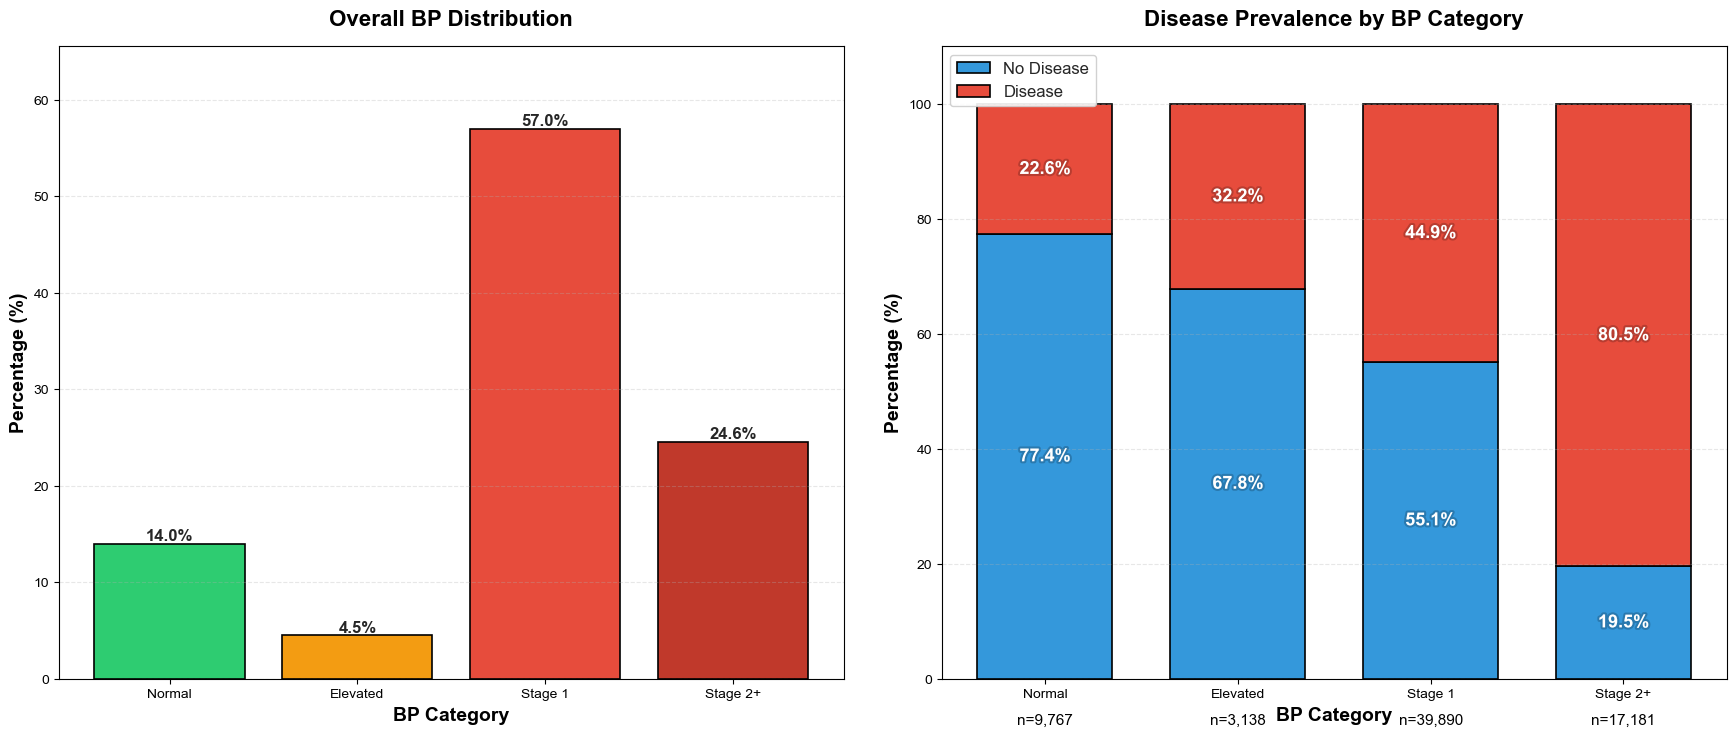

In [14]:
import matplotlib.patheffects

def classify_bp(row):
    try:
        # First check if values exist and can be converted to float
        if pd.isna(row['Systolic_BP']) or pd.isna(row['Diastolic_BP']):
            return np.nan
            
        sbp = float(row['Systolic_BP'])
        dbp = float(row['Diastolic_BP'])
        
        # Then check for negative values
        if sbp < 0 or dbp < 0:
            return np.nan
    except Exception:
        return np.nan

    if sbp < 120 and dbp < 80:
        return 1  # Normal
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2  # Elevated
    elif (130 <= sbp <= 139) or (80 <= dbp <= 89):
        return 3  # Hypertension Stage 1
    elif sbp >= 140 or dbp >= 90: 
        return 4  # Hypertension Stage 2+
    else:
        return np.nan

# Define BP labels and order
bp_labels = {
    1: 'Normal',
    2: 'Elevated',
    3: 'Stage 1',
    4: 'Stage 2+'
}
bp_order = list(bp_labels.values())

# Apply classification
df['BP_level'] = df.apply(classify_bp, axis=1)
df['BP_label'] = df['BP_level'].map(bp_labels)
df['BP_label'] = pd.Categorical(df['BP_label'], categories=bp_order, ordered=True)
df['BP_level'] = df['BP_level'].astype('category')
df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

# Print classification summary
print("BP Classification Summary:")
print(df['BP_label'].value_counts().sort_index())
print(f"\nTotal records: {len(df)}")
print(f"Records with BP classification: {df['BP_label'].notna().sum()}")

# --- Create figure with subplots (1 row, 2 columns) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- LEFT PLOT: Overall BP Distribution (without target label) ---
plot_data_overall = df['BP_label'].value_counts(normalize=True).reindex(bp_order).reset_index()
plot_data_overall.columns = ['BP_label', 'percent']
plot_data_overall['percent'] *= 100

colors_overall = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b']

bars_left = axes[0].bar(
    plot_data_overall['BP_label'],
    plot_data_overall['percent'],
    color=colors_overall,
    edgecolor='black',
    linewidth=1.2
)

axes[0].set_title('Overall BP Distribution', fontsize=16, weight='bold', pad=15)
axes[0].set_xlabel('BP Category', fontsize=14, weight='bold')
axes[0].set_ylabel('Percentage (%)', fontsize=14, weight='bold')
axes[0].set_ylim(0, max(plot_data_overall['percent']) * 1.15)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels on the bars
for bar in bars_left:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2., height,
        f'{height:.1f}%', ha='center', va='bottom',
        fontsize=12, weight='bold'
    )

# --- RIGHT PLOT: Stacked Bar Chart by Target ---
plot_data_stacked = (
    df.dropna(subset=['BP_label', 'target_name'])
      .groupby(['BP_label', 'target_name'])
      .size()
      .unstack(fill_value=0)
)
plot_data_pct = plot_data_stacked.div(plot_data_stacked.sum(axis=1), axis=0) * 100

x = np.arange(len(bp_order))
width = 0.7  # Slightly wider bars

color_no_disease = '#3498db'
color_disease = '#e74c3c'

no_disease_pct = [plot_data_pct.loc[cat, 'No Disease'] if cat in plot_data_pct.index else 0 for cat in bp_order]
disease_pct = [plot_data_pct.loc[cat, 'Disease'] if cat in plot_data_pct.index else 0 for cat in bp_order]

bar1 = axes[1].bar(x, no_disease_pct, width, label='No Disease', 
                  color=color_no_disease, edgecolor='black', linewidth=1.2)
bar2 = axes[1].bar(x, disease_pct, width, bottom=no_disease_pct, label='Disease', 
                  color=color_disease, edgecolor='black', linewidth=1.2)

axes[1].set_title('Disease Prevalence by BP Category', fontsize=16, weight='bold', pad=15)
axes[1].set_xlabel('BP Category', fontsize=14, weight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=14, weight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(bp_order)
axes[1].set_ylim(0, 110)  # Increased to make room for labels
axes[1].legend(loc='upper left', fontsize=12, framealpha=0.9)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Improved label formatting for better readability
for i, (bp_cat, no_dis_val, dis_val) in enumerate(zip(bp_order, no_disease_pct, disease_pct)):
    # No disease labels (blue bars) - always show percentage
    axes[1].text(
        i, no_dis_val / 2, f'{no_dis_val:.1f}%',
        ha='center', va='center', fontsize=13,
        weight='bold', color='white',
        path_effects=[
            matplotlib.patheffects.withStroke(linewidth=3, foreground='black', alpha=0.2)
        ]
    )
    
    # Disease labels (red bars) - always show percentage
    axes[1].text(
        i, no_dis_val + (dis_val / 2), f'{dis_val:.1f}%',
        ha='center', va='center', fontsize=13,
        weight='bold', color='white',
        path_effects=[
            matplotlib.patheffects.withStroke(linewidth=3, foreground='black', alpha=0.2)
        ]
    )

# Add category counts as x-axis labels with totals
category_counts = df['BP_label'].value_counts().reindex(bp_order)
for i, (bp_cat, count) in enumerate(category_counts.items()):
    axes[1].text(
        i, -6, f'n={count:,}',
        ha='center', va='top',
        fontsize=11, color='black'
    )

plt.tight_layout(pad=3.0)
plt.show()

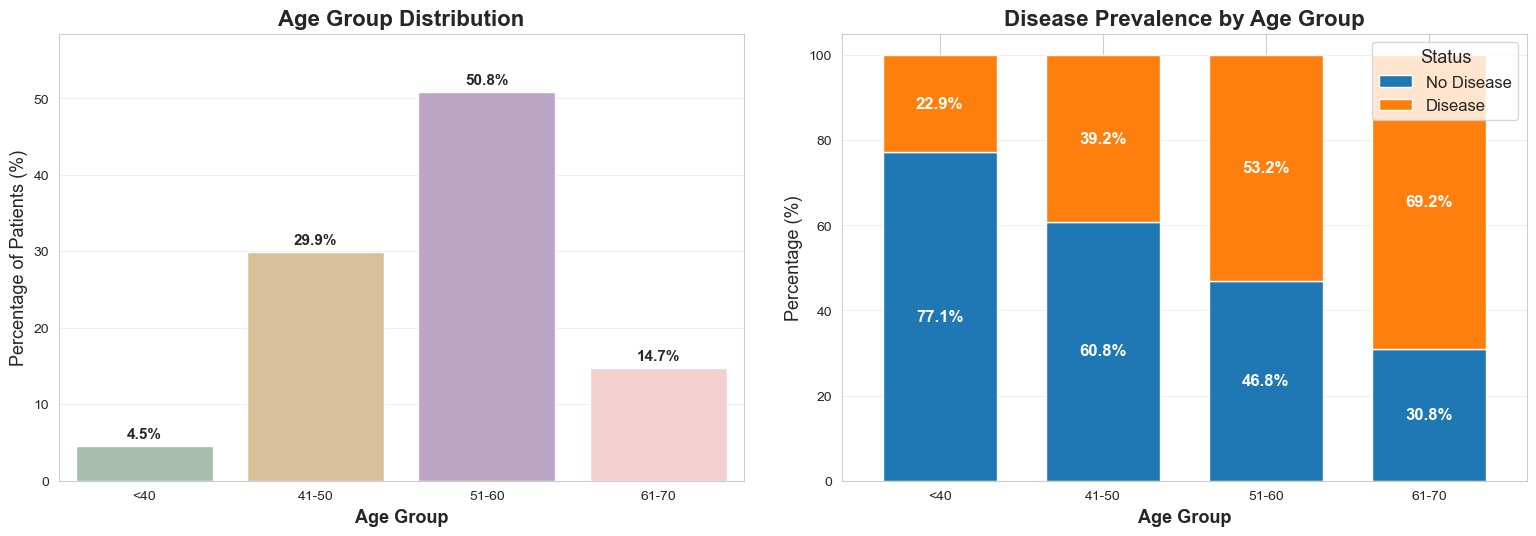

In [15]:
AGE_BINS = [0, 40, 50, 60, 70, 100]
AGE_LABELS = ['<40', '41-50', '51-60', '61-70', '>70']

if 'Age_Years' in df.columns:
    # Remove invalid ages
    valid_mask = df['Age_Years'].between(AGE_BINS[0], AGE_BINS[-1])
    df = df[valid_mask].copy()

    # Create Age_Group
    df['Age_Group'] = pd.cut(df['Age_Years'], bins=AGE_BINS, labels=AGE_LABELS, 
                            right=True, include_lowest=True)
    
    # Map target to human-readable name
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

    # Only keep present age groups for plotting
    present_labels = df['Age_Group'].cat.categories[df['Age_Group'].value_counts().sort_index() > 0].tolist()

    # --- Create figure with subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.set_style("whitegrid")
    
    # --- Color palettes ---
    left_palette = ['#a3c1ad', '#e2c290', '#bfa0c9', '#f7cac9', '#7b9acc']
    right_palette = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

    # --- LEFT PLOT: Overall Age Distribution ---
    # Get counts and percentages
    age_counts = df['Age_Group'].value_counts().reindex(present_labels)
    plot_data_overall = df['Age_Group'].value_counts(normalize=True).reindex(present_labels).reset_index()
    plot_data_overall.columns = ['Age_Group', 'percent']
    plot_data_overall['percent'] *= 100

    # Create bar plot
    bars_left = sns.barplot(
        data=plot_data_overall,
        x='Age_Group', y='percent',
        order=present_labels,
        ax=axes[0],
        palette=left_palette
    )
    
    # Add percentage labels only (removed count labels)
    for i, p in enumerate(axes[0].patches):
        height = p.get_height()
        axes[0].text(
            p.get_x() + p.get_width()/2., 
            height + 1, 
            f'{height:.1f}%', 
            ha='center', fontsize=11, fontweight='bold'
        )

    # Customize first plot
    axes[0].set_title('Age Group Distribution', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Age Group', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Percentage of Patients (%)', fontsize=13)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim(0, max(plot_data_overall['percent']) * 1.15)  # Add headroom for labels

    # --- RIGHT PLOT: Disease Risk by Age Group ---
    # Get crosstab of age group vs. disease status
    disease_by_age = pd.crosstab(
        df['Age_Group'], 
        df['target_name'],
        normalize='index'
    ) * 100
    
    # Ensure all age groups are included
    disease_by_age = disease_by_age.reindex(present_labels)
    
    # Plot stacked bars
    disease_by_age.plot(
        kind='bar',
        stacked=True,
        ax=axes[1],
        color=right_palette,
        width=0.7
    )
    
    # Add percentage labels
    prev_heights = np.zeros(len(disease_by_age))
    for i, col in enumerate(disease_by_age.columns):
        for j, (idx, val) in enumerate(disease_by_age[col].items()):
            # Skip very small segments
            if val < 3:
                continue
                
            # Calculate label position
            height = prev_heights[j] + val/2
            axes[1].text(
                j, height, f'{val:.1f}%', 
                ha='center', va='center', fontsize=12, 
                color='white', fontweight='bold'
            )
            prev_heights[j] += val

    # Customize second plot
    axes[1].set_title('Disease Prevalence by Age Group', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Age Group', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Percentage (%)', fontsize=13)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim(0, 105)  # Leave space for labels
    axes[1].set_xticklabels(present_labels, rotation=0)
    axes[1].legend(title='Status', fontsize=12, title_fontsize=13)

    plt.tight_layout(pad=3)
    plt.show()

    # Clean up target_name if we need to
    if 'target_name' in df.columns:
        df = df.drop(['target_name'], axis=1, errors='ignore')

# Clean up variables
del AGE_BINS, AGE_LABELS
if 'valid_mask' in locals(): del valid_mask
if 'present_labels' in locals(): del present_labels
if 'plot_data_overall' in locals(): del plot_data_overall

### **Observations:**

* **Patient Population**
The study is mostly focused on middle-aged people. **Over half of all patients are in their 50s**.

* **Disease Risk by Age**
Age is a massive risk factor. The link is very clear: the older you get, the higher the risk of disease.

* **Key Insight**
While the largest group of patients is in their 50s, the **highest risk of disease** is found in the oldest group (`61-70`). The chance of having the disease **triples** from the youngest group (23%) to the oldest group (69%).

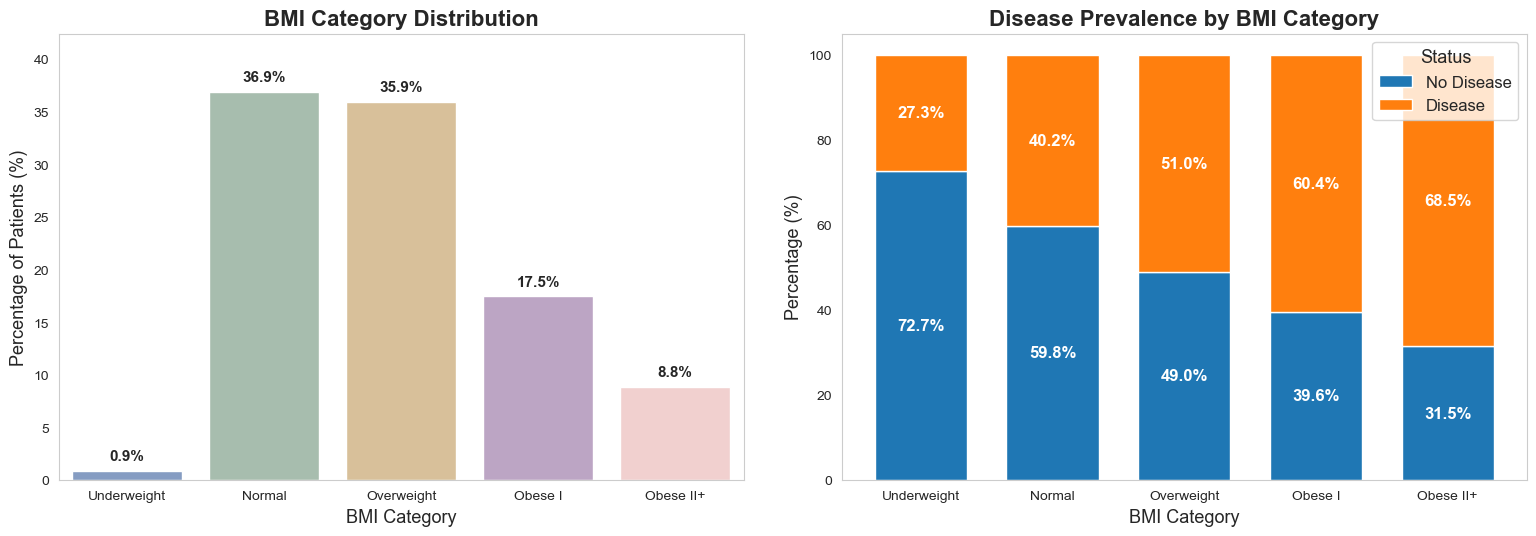

Plot created with 69976 BMI data points


In [16]:
# ---------------------------
# BMI Categorization and Barplot with/without Target
# ---------------------------
BMI_BINS = [0, 18.5, 25, 30, 35, float('inf')]
BMI_LABELS = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+']

# Check if BMI column exists and has data
if 'BMI' in df.columns and df['BMI'].notna().any():
    # Create BMI_Category
    df['BMI_Category'] = pd.cut(df['BMI'], bins=BMI_BINS, labels=BMI_LABELS, right=False)
    
    # Map target for right plot only
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})
    
    # --- Subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.set_style("whitegrid")
    left_palette = ['#7b9acc', '#a3c1ad', '#e2c290', '#bfa0c9', '#f7cac9']  # Soft, non-blue/orange colors
    right_palette = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

    # --- LEFT PLOT: Overall distribution (no target label, different colors) ---
    # Get category counts and percentages
    bmi_counts = df['BMI_Category'].value_counts()
    plot_data_overall = df['BMI_Category'].value_counts(normalize=True).reindex(BMI_LABELS).reset_index()
    plot_data_overall.columns = ['BMI_Category', 'percent']
    plot_data_overall['percent'] *= 100

    # Create bar plot
    bars_left = sns.barplot(
        data=plot_data_overall,
        x='BMI_Category', y='percent',
        order=BMI_LABELS,
        ax=axes[0],
        palette=left_palette
    )
    
    # Add percentage labels
    for i, p in enumerate(axes[0].patches):
        height = p.get_height()
        axes[0].text(
            p.get_x() + p.get_width()/2., 
            height + 1, 
            f'{height:.1f}%', 
            ha='center', fontsize=11, fontweight='bold'
        )

    # Customize first plot
    axes[0].set_title('BMI Category Distribution', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('BMI Category', fontsize=13)
    axes[0].set_ylabel('Percentage of Patients (%)', fontsize=13)
    axes[0].grid(False)
    axes[0].set_xticklabels(BMI_LABELS, rotation=0)
    axes[0].set_ylim(0, max(plot_data_overall['percent']) * 1.15)  # Add headroom for labels

    # --- RIGHT PLOT: Distribution by Target (target label, blue/orange) ---
    # Get crosstab of BMI category vs. disease status
    disease_by_bmi = pd.crosstab(
        df['BMI_Category'], 
        df['target_name'],
        normalize='index'
    ) * 100
    
    # Ensure all BMI categories are included
    disease_by_bmi = disease_by_bmi.reindex(BMI_LABELS)
    
    # Plot stacked bars
    disease_by_bmi.plot(
        kind='bar',
        stacked=True,
        ax=axes[1],
        color=right_palette,
        width=0.7
    )
    
    # Add percentage labels
    prev_heights = np.zeros(len(disease_by_bmi))
    for i, col in enumerate(disease_by_bmi.columns):
        for j, (idx, val) in enumerate(disease_by_bmi[col].items()):
            # Skip very small segments
            if val < 3:
                continue
                
            # Calculate label position
            height = prev_heights[j] + val/2
            axes[1].text(
                j, height, f'{val:.1f}%', 
                ha='center', va='center', fontsize=12, 
                color='white', fontweight='bold'
            )
            prev_heights[j] += val

    # Customize second plot
    axes[1].set_title('Disease Prevalence by BMI Category', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('BMI Category', fontsize=13)
    axes[1].set_ylabel('Percentage (%)', fontsize=13)
    axes[1].grid(False)
    axes[1].set_ylim(0, 105)  # Leave space for labels
    axes[1].set_xticklabels(BMI_LABELS, rotation=0)
    axes[1].legend(title='Status', fontsize=12, title_fontsize=13)

    plt.tight_layout(pad=3)
    plt.show()
    
    print(f"Plot created with {df['BMI_Category'].notna().sum()} BMI data points")

    # --- Cleanup ---
    df.drop(['target_name'], axis=1, inplace=True, errors='ignore')
else:
    if 'BMI' not in df.columns:
        print("Error: 'BMI' column not found in the dataframe")
    else:
        print(f"Error: 'BMI' column exists but contains no valid data (all NaN)")

# Cleanup variables
del BMI_BINS, BMI_LABELS

### **Observations:**
Most of the patients in this study fall into the **'Normal'** or **'Overweight'** BMI groups, which are almost equal in size. Very few people in this group are underweight.

**Disease Risk by BMI**
Higher BMI is a **major risk factor**. The trend is very clear: as the BMI category increases, the chance of having the disease gets progressively higher.

**Key Insight**
The risk of disease climbs steadily from one category to the next. The chance of having the disease is lowest for 'Underweight' people (27.5%) and highest for the most obese group (**68.4%**).

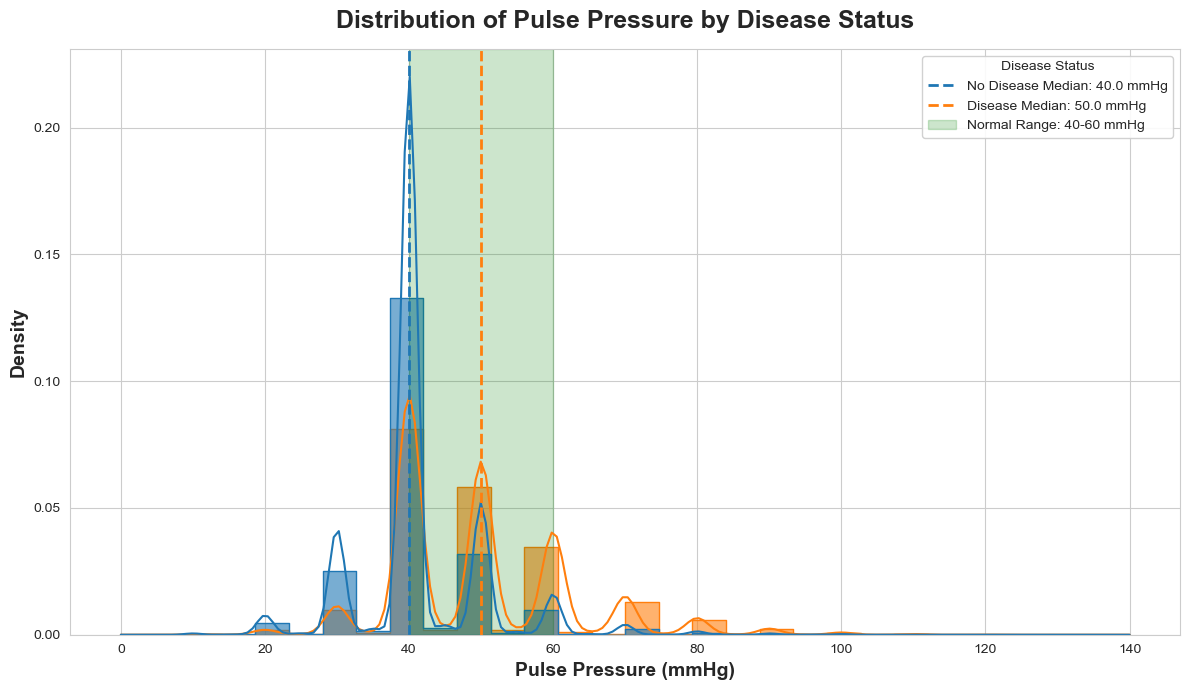

In [17]:
# Feature engineering - Calculate Pulse Pressure
df['Pulse_Pressure'] = df['Systolic_BP'] - df['Diastolic_BP']

# Ensure target_name is defined for plotting
if 'target_name' not in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

# Define TARGET_PALETTE if not already defined
TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

# Create figure with improved styling
plt.figure(figsize=(12, 7))
sns.set_style('whitegrid')

# Plot distribution with both histogram and density curve
ax = sns.histplot(
    data=df, 
    x='Pulse_Pressure', 
    hue='target_name',
    bins=30,
    kde=True,  # Add density curves
    stat='density',  # Use density instead of count for better comparison
    alpha=0.6,  # Make bars semi-transparent
    palette=TARGET_PALETTE,
    element='step',  # Use step-style histograms for cleaner look
    common_norm=False  # Separate normalization for better group comparison
)

# Add vertical lines for group medians
for target, color in TARGET_PALETTE.items():
    median_val = df[df['target_name'] == target]['Pulse_Pressure'].median()
    plt.axvline(x=median_val, color=color, linestyle='--', linewidth=2, 
                label=f'{target} Median: {median_val:.1f} mmHg')

# Add normal range shading but with a label for the legend
plt.axvspan(40, 60, alpha=0.2, color='green', label='Normal Range: 40-60 mmHg')

# Create legend with all elements
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, 
           labels=labels,
           title='Disease Status',
           loc='upper right',
           frameon=True,
           framealpha=0.9)

# Enhance plot styling
plt.title('Distribution of Pulse Pressure by Disease Status', fontsize=18, weight='bold', pad=15)
plt.xlabel('Pulse Pressure (mmHg)', fontsize=14, weight='bold')
plt.ylabel('Density', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [18]:
# Check missing % per column
missing_pct = df.isna().mean() * 100
missing_pct

Age_Years            0.0
Sex                  0.0
Systolic_BP          0.0
Diastolic_BP         0.0
Cholesterol_Level    0.0
Glucose_Level        0.0
Smoking_Status       0.0
Alcohol_Intake       0.0
Physical_Activity    0.0
target               0.0
BMI                  0.0
BP_level             0.0
BP_label             0.0
Age_Group            0.0
BMI_Category         0.0
Pulse_Pressure       0.0
target_name          0.0
dtype: float64

# Exploratory Data Analysis

### Numerical Analysis

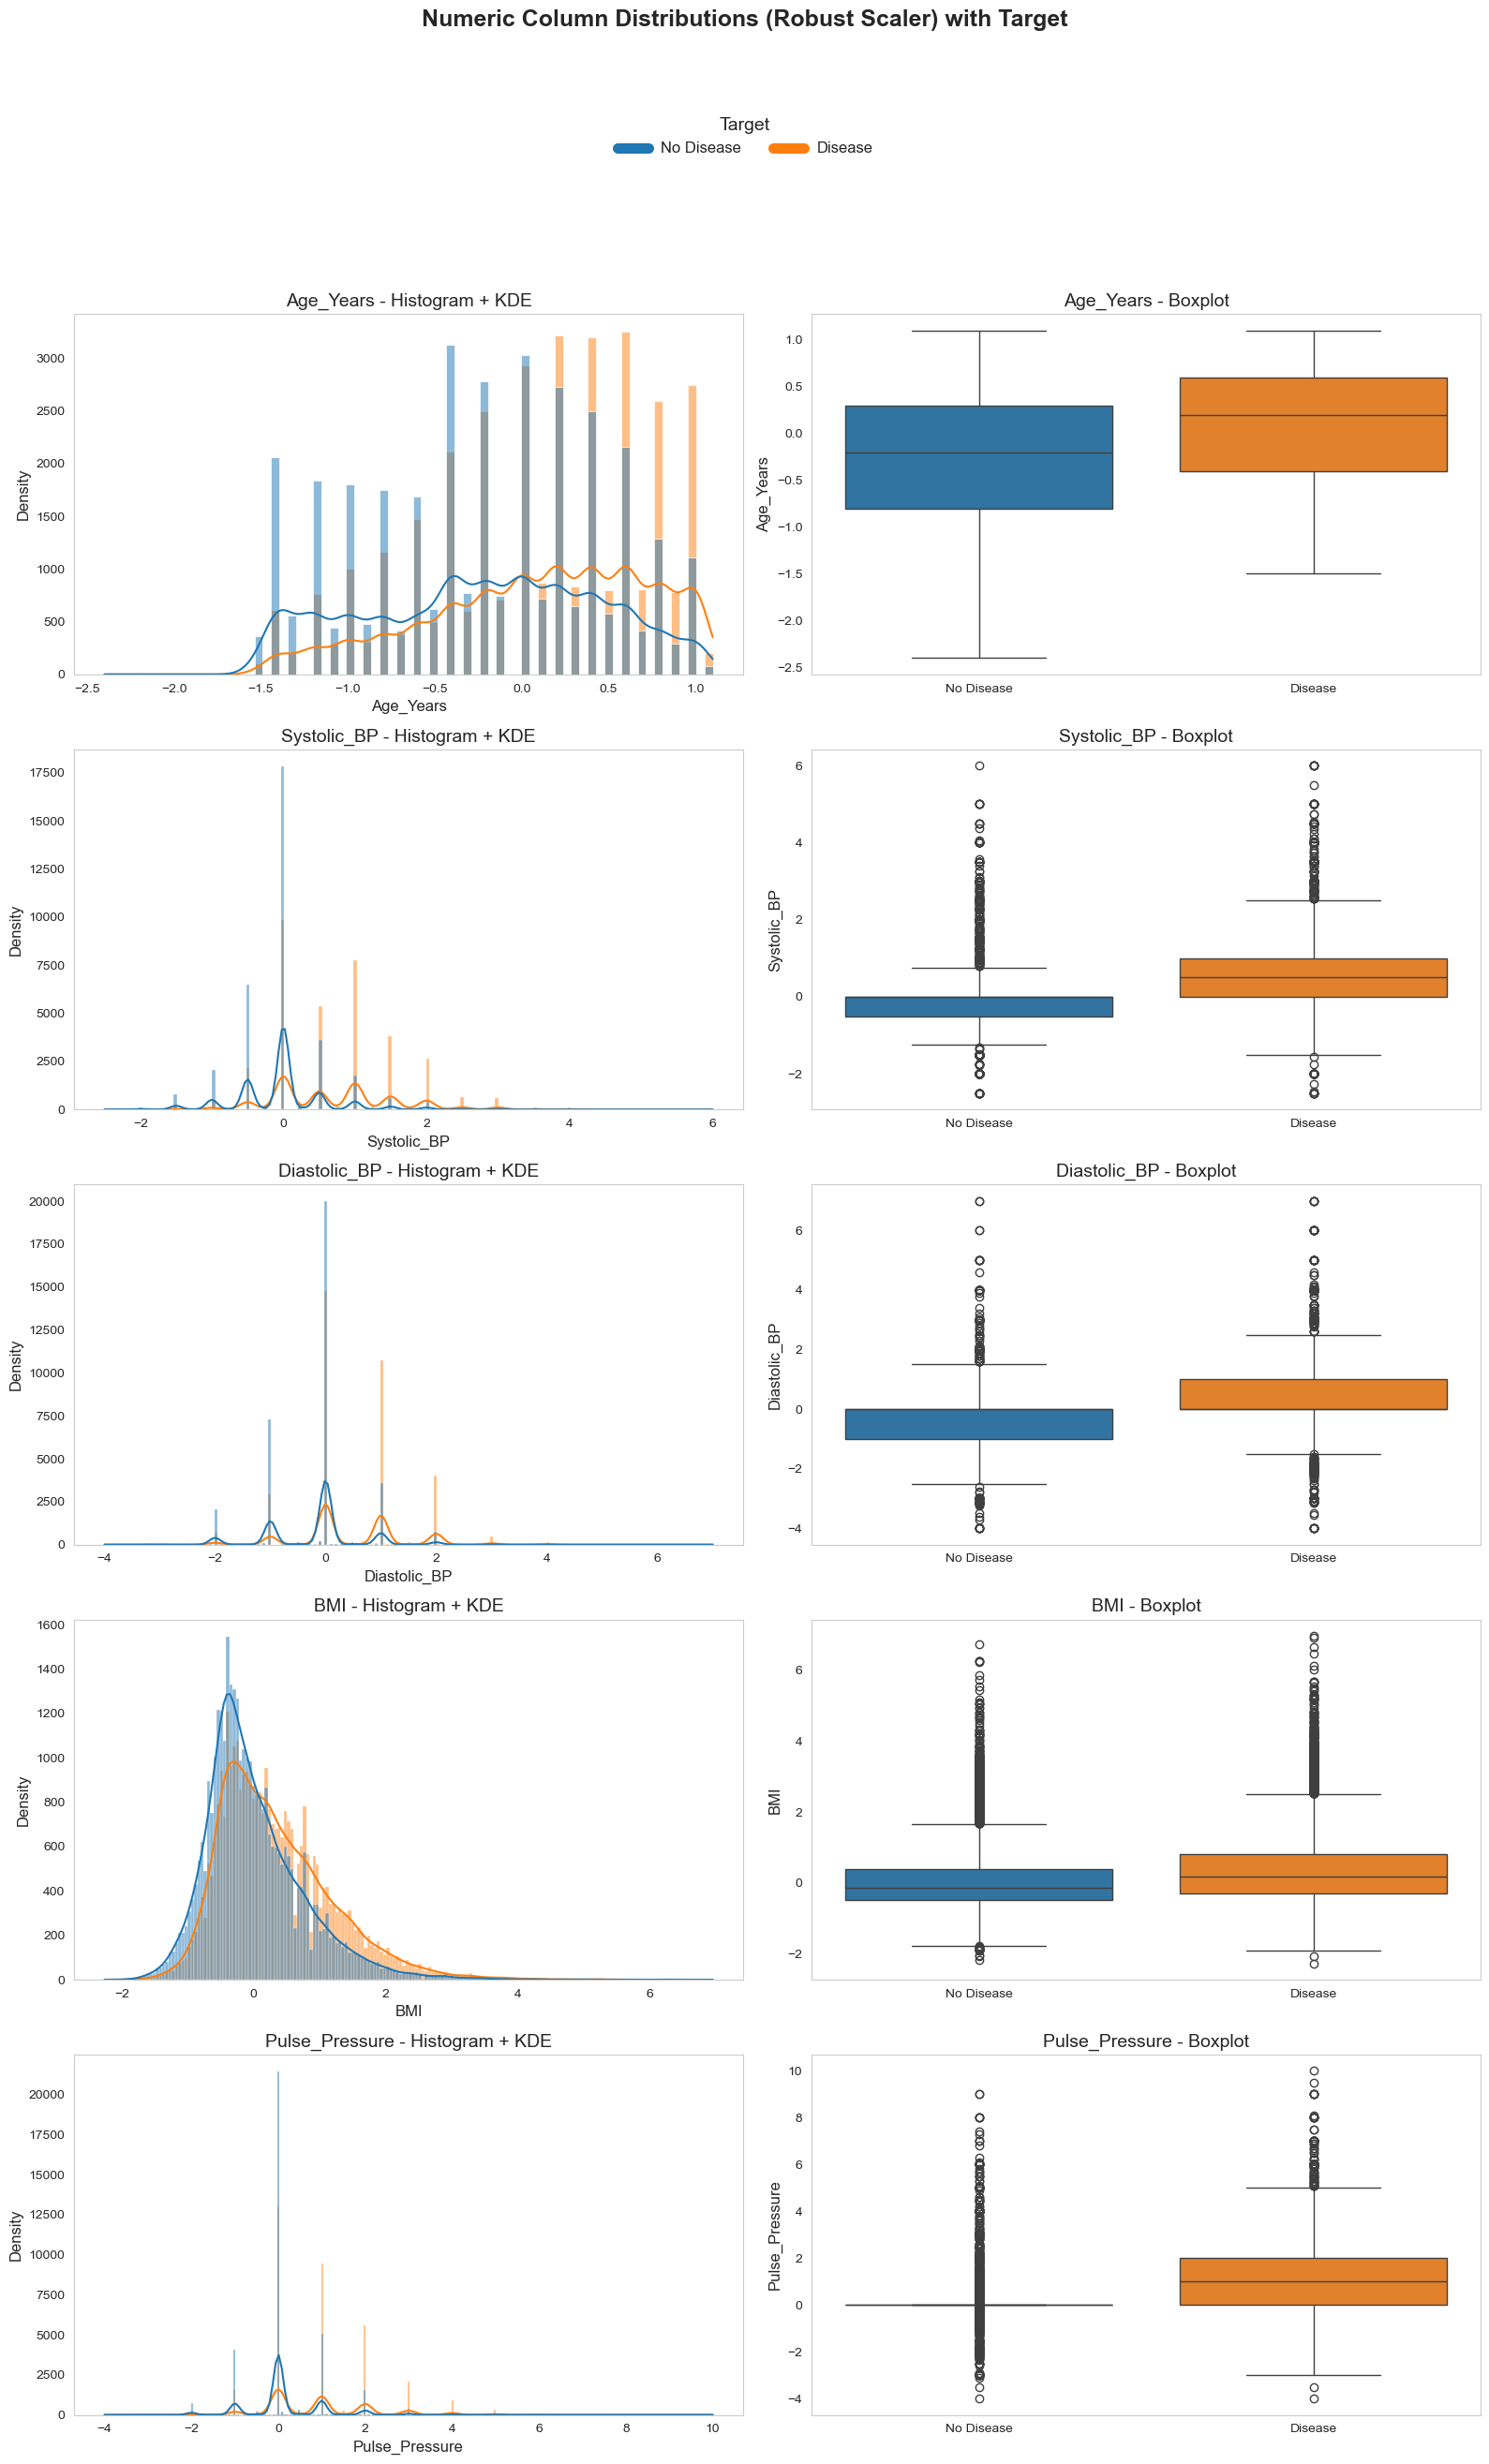

In [19]:
import joblib

# ---------------------------
# Columns to scale
# ---------------------------
numeric_cols = ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI', 'Pulse_Pressure']

# ---------------------------
# Target mapping
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

# ---------------------------
# Set up output directories (two levels up from src)
# ---------------------------
try:
    PROJECT_ROOT = Path.cwd().parent.parent.resolve()  # two levels up from src/notebooks
    ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
    PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'numerical analysis'
    ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
    PLOT_DIR.mkdir(parents=True, exist_ok=True)
except Exception as e:
    # Fallback to current directory if there's an issue
    ARTIFACTS_DIR = Path.cwd() / 'artifacts'
    PLOT_DIR = Path.cwd()
    ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Apply RobustScaler on original DataFrame
# ---------------------------
scaler = RobustScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Save the fitted scaler (outside src in artifacts folder)
scaler_path = ARTIFACTS_DIR / 'robust_scaler_numeric.pkl'
joblib.dump(scaler, scaler_path)

# ---------------------------
# Figure layout: 2 columns per row
# ---------------------------
n_rows = len(numeric_cols)
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows), squeeze=False)

# Main title
fig.suptitle(
    'Numeric Column Distributions (Robust Scaler) with Target',
    fontsize=18, weight='bold', y=1.05
)

# ---------------------------
# Plotting
# ---------------------------
for i, col in enumerate(numeric_cols):
    # --- Left: Histogram + KDE ---
    sns.histplot(
        data=df, x=col, hue='target_name', palette=TARGET_PALETTE,
        kde=True, ax=axes[i, 0], legend=False
    )
    axes[i, 0].set_title(f'{col} - Histogram + KDE', fontsize=14)
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Density', fontsize=12)
    axes[i, 0].tick_params(axis='both', labelsize=10)
    axes[i, 0].grid(False)

    # --- Right: Boxplot ---
    sns.boxplot(
        data=df, x='target_name', y=col,
        palette=TARGET_PALETTE, ax=axes[i, 1], dodge=False, showfliers=True
    )
    axes[i, 1].set_title(f'{col} - Boxplot', fontsize=14)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel(col, fontsize=12)
    axes[i, 1].tick_params(axis='both', labelsize=10)
    axes[i, 1].grid(False)
    axes[i, 1].set_xticklabels(list(TARGET_PALETTE.keys()))

# ---------------------------
# Single horizontal legend below title
# ---------------------------
handles = [Line2D([0], [0], color=TARGET_PALETTE[name], lw=8, label=name) for name in TARGET_PALETTE]
fig.legend(
    handles=handles, labels=list(TARGET_PALETTE.keys()), title='Target',
    title_fontsize=14, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.01),
    ncol=len(TARGET_PALETTE), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.95))

# ---------------------------
# Save figure (outside src in reports folder)
# ---------------------------
img_path = PLOT_DIR / '01_Numeric_Columns_Distributions_RobustScaler.png'
plt.savefig(img_path, bbox_inches='tight', dpi=150, facecolor='white')
plt.show()

***Observations:***

* ***Age is a Major Factor:*** The charts clearly show that patients with the disease are older.

* ***Blood Pressure is a Strong Sign:*** All blood pressure readings (Systolic, Diastolic, and Pulse Pressure) are noticeably higher in the group with the disease.

* ***BMI Shows a Connection:*** Higher BMI is linked to the disease, but the difference between the groups is less dramatic than it is for age and blood pressure.

***Main Takeaway:*** While all the metrics are important, age and high blood pressure are the strongest and most obvious indicators of the disease in these graphs.

[INFO] Using output directory: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\numerical analysis
[INFO] Removed existing file: 02_Pairwise_Relationships_of_Numeric_Features.png
[SUCCESS] Plot saved to: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\numerical analysis\02_Pairwise_Relationships_of_Numeric_Features.png


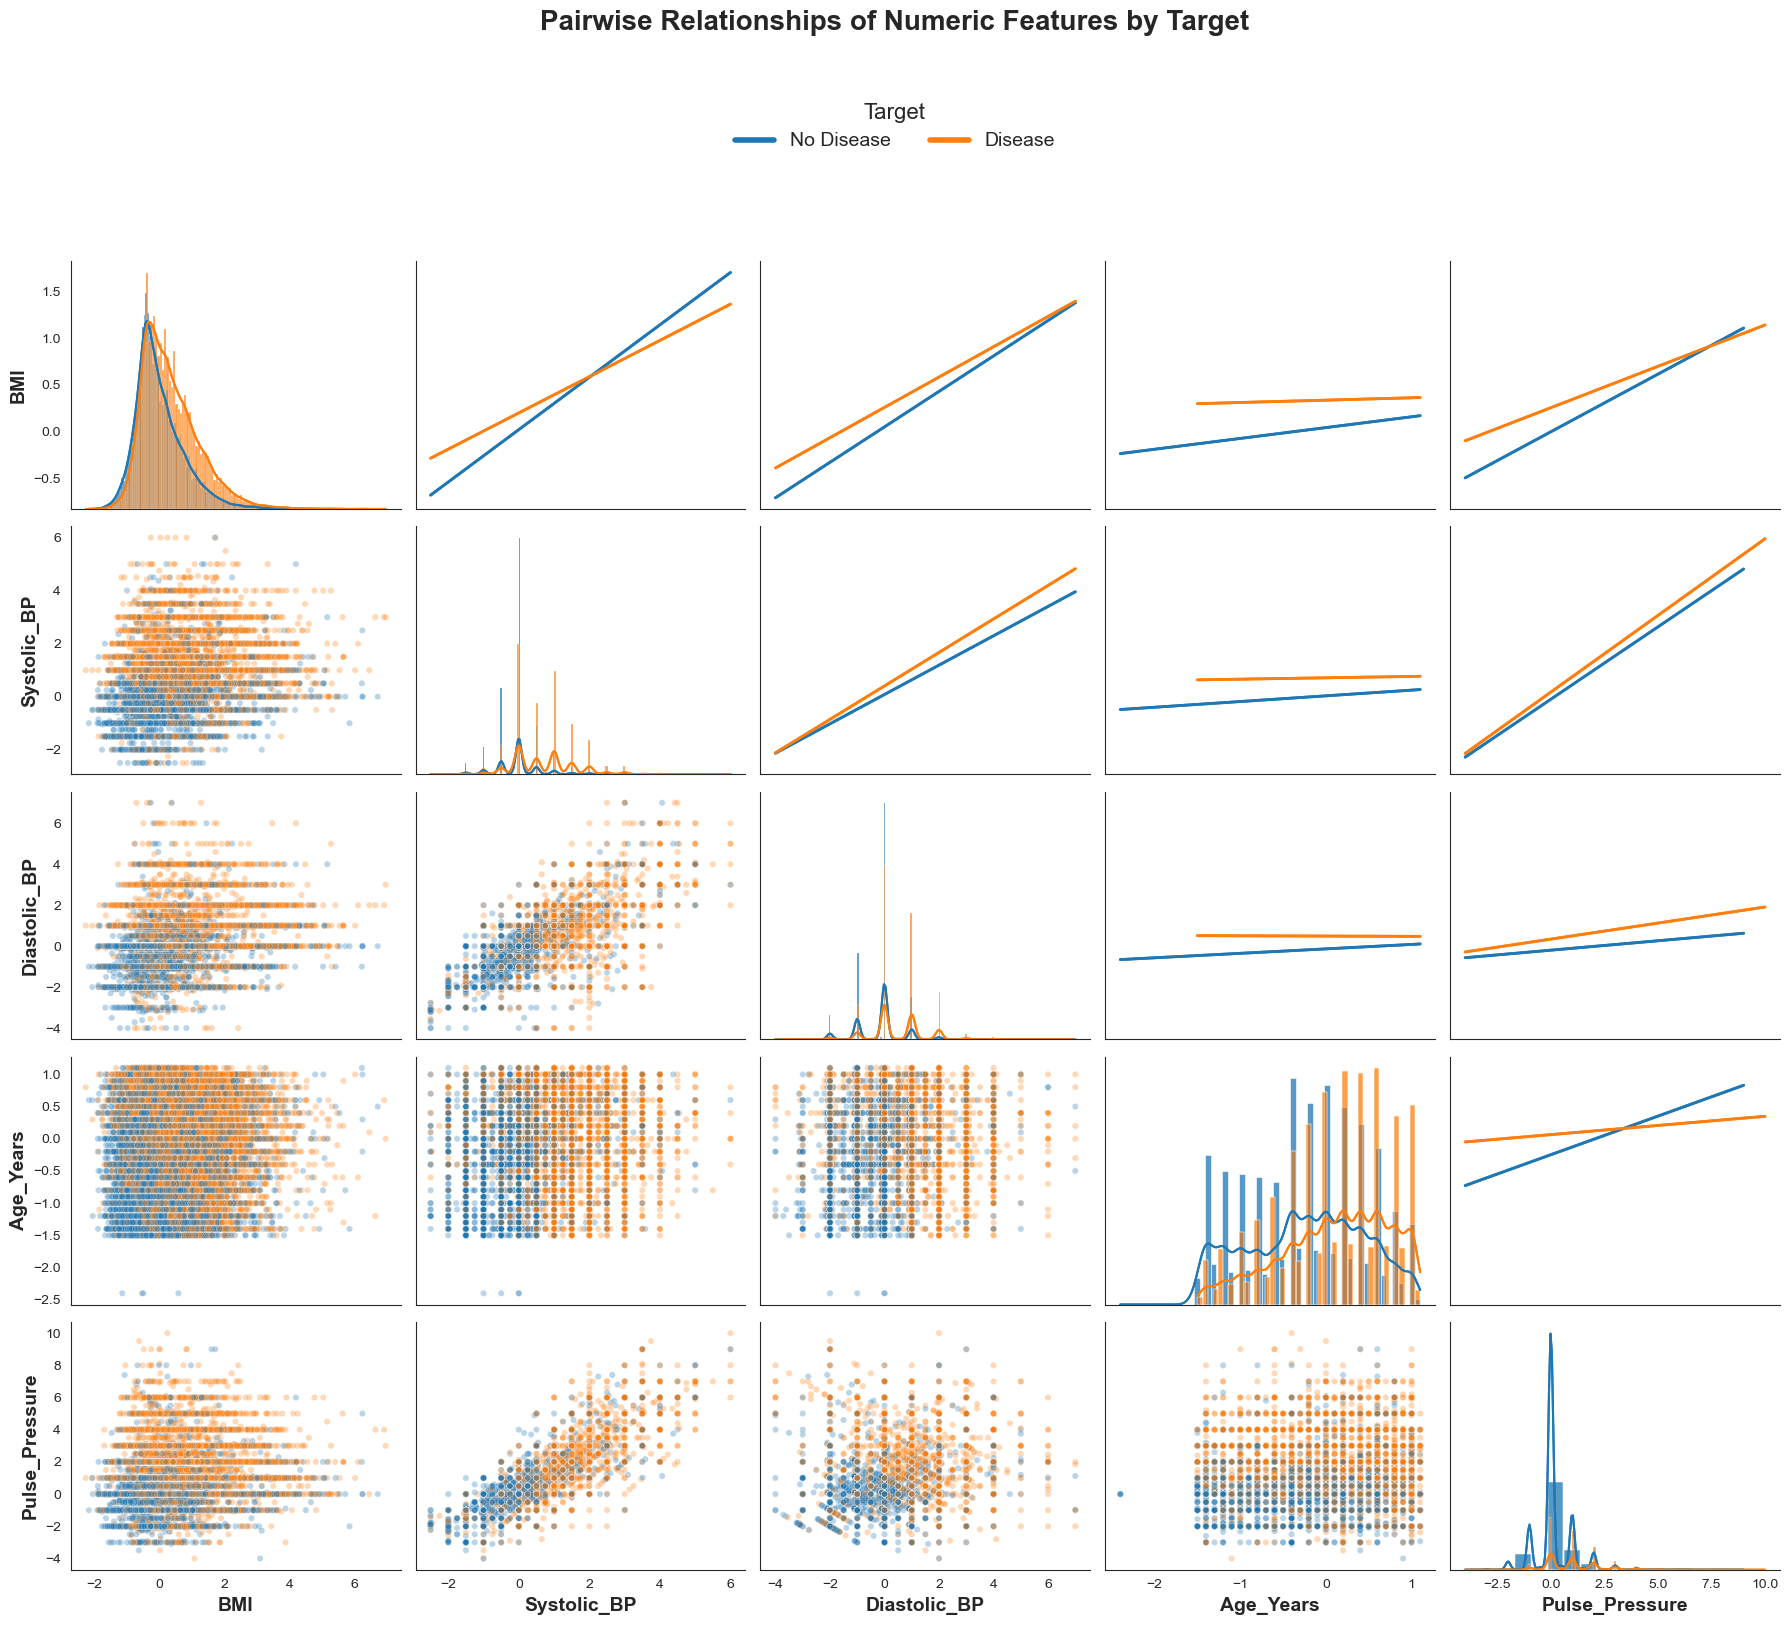

In [20]:
# ---------------------------
# Project root and plot directory outside src
# ---------------------------
try:
    PROJECT_ROOT = Path.cwd().parent.parent.resolve()  # two levels up from src/notebooks
    PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'numerical analysis'
    PLOT_DIR.mkdir(parents=True, exist_ok=True)  # create folder only if missing
    print(f"[INFO] Using output directory: {PLOT_DIR.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not set up output directory: {e}")
    # Fallback to current directory if there's an issue
    PLOT_DIR = Path.cwd()
    print(f"[INFO] Falling back to current directory: {PLOT_DIR}")

# ---------------------------
# Numeric columns
# ---------------------------
numeric_cols = ['BMI', 'Systolic_BP', 'Diastolic_BP', 'Age_Years', 'Pulse_Pressure']

# ---------------------------
# Target palette
# ---------------------------
TARGET_PALETTE_LIST = ['#1f77b4', '#ff7f0e']  # Blue for No Disease, Orange for Disease
PAIRGRID_PALETTE = dict(zip(['No Disease', 'Disease'], TARGET_PALETTE_LIST))

# ---------------------------
# Prepare DataFrame - avoid modifying original data
# ---------------------------
df_plot = df.copy()
df_plot['target_name'] = df_plot['target'].map({0: 'No Disease', 1: 'Disease'})

# ---------------------------
# Figure sizing based on number of variables
# ---------------------------
n_vars = len(numeric_cols)
fig_height = max(3 * n_vars, 10)  # Minimum height of 10
fig_width = fig_height * 1.2

# ---------------------------
# Styling
# ---------------------------
plt.rcParams['axes.grid'] = False
sns.set_style("white")  # no grid lines

# ---------------------------
# Initialize PairGrid
# ---------------------------
g = sns.PairGrid(
    df_plot,
    vars=numeric_cols,
    hue='target_name',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False,
    height=fig_height/n_vars,
    aspect=1.2
)

# ---------------------------
# Upper: regression lines
# ---------------------------
def reg_by_target(x, y, **kwargs):
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        # Only plot regression if we have enough data points
        if subset[x.name].notna().sum() > 2 and subset[y.name].notna().sum() > 2:
            sns.regplot(
                x=subset[x.name], y=subset[y.name], scatter=False, ci=None,
                line_kws={'color': color, 'label': name, 'linewidth': 2}, ax=plt.gca()
            )

g.map_upper(reg_by_target)

# ---------------------------
# Lower: scatter plot
# ---------------------------
g.map_lower(sns.scatterplot, alpha=0.3, s=20)

# ---------------------------
# Diagonal: histogram
# ---------------------------
def hist_diag(x, **kwargs):
    ax = plt.gca()
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 1:
            sns.histplot(subset[x.name], color=color, alpha=0.5, kde=True, ax=ax)
    # Remove redundant legend if it exists
    if ax.get_legend():
        ax.get_legend().remove()

g.map_diag(hist_diag)

# ---------------------------
# Remove grid lines from all axes
# ---------------------------
for ax_row in g.axes:
    for ax in ax_row:
        ax.grid(False)

# ---------------------------
# Main title
# ---------------------------
g.fig.suptitle('Pairwise Relationships of Numeric Features by Target', 
             fontsize=20, y=1.08, weight='bold')

# ---------------------------
# Legend below title
# ---------------------------
handles = [plt.Line2D([0], [0], color=color, lw=4, label=name) 
          for name, color in PAIRGRID_PALETTE.items()]
labels = list(PAIRGRID_PALETTE.keys())
g.fig.legend(
    handles, labels, title='Target', title_fontsize=16, fontsize=14,
    loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, frameon=False
)

# ---------------------------
# Axis labels font size
# ---------------------------
for i, var in enumerate(numeric_cols):
    g.axes[i, 0].set_ylabel(var, fontsize=14, fontweight='bold')
    g.axes[-1, i].set_xlabel(var, fontsize=14, fontweight='bold')

plt.tight_layout(rect=(0, 0, 1, 0.95))

# ---------------------------
# Save figure with robust error handling
# ---------------------------
try:
    img_path = PLOT_DIR / '02_Pairwise_Relationships_of_Numeric_Features.png'
    
    # Remove previous file if exists
    if img_path.exists():
        img_path.unlink()
        print(f"[INFO] Removed existing file: {img_path.name}")
    
    # Save the plot
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {str(e)}")
finally:
    plt.show()  # Always show the plot regardless of save success

# Clean up memory
plt.close()

### ***Observations:***

* ***Age is the biggest factor:*** Older people are much more likely to have the disease.

* ***High blood pressure is a clear sign:*** People with the disease tend to have higher systolic, diastolic, and pulse pressure readings.

* ***Higher BMI is also linked:*** A higher BMI increases the chances of having the disease, though it's not as strong a factor as age or blood pressure.

***Risks add up:*** The data shows that the highest concentration of disease is among older individuals with high blood pressure.

In [21]:
# ==============================================================================
# NUMERICAL ANALYSIS: Statistical Comparison & Correlation (Strength & Direction)
# ==============================================================================

# Define columns to analyze and target column
numeric_cols = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure']
target_col = 'target'

# Validate columns exist in dataframe
missing_cols = [col for col in numeric_cols + [target_col] if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataframe: {', '.join(missing_cols)}")

# Set significance level
alpha = 0.05
results = []

# Process each numeric feature
for col in numeric_cols:
    # Filter out NaN values for more robust analysis
    valid_data = df[[col, target_col]].dropna()
    
    # Skip if insufficient data
    if len(valid_data) < 10:
        print(f"Warning: Insufficient data for {col}, skipping...")
        continue
        
    group0 = valid_data[valid_data[target_col] == 0][col]
    group1 = valid_data[valid_data[target_col] == 1][col]
    
    # Skip if any group is too small
    if len(group0) < 5 or len(group1) < 5:
        print(f"Warning: Group size too small for {col}, skipping...")
        continue
    
    # Perform Mann-Whitney U test (non-parametric comparison of distributions)
    stat, p_mwu = mannwhitneyu(group0, group1, alternative='two-sided')
    
    # Calculate descriptive statistics
    median0 = group0.median()
    median1 = group1.median()
    mean0 = group0.mean()
    mean1 = group1.mean()
    
    # Determine direction of difference between groups
    if median1 > median0:
        mwu_direction = "higher"
    elif median1 < median0:
        mwu_direction = "lower"
    else:
        mwu_direction = "equal"
        
    # Calculate Spearman correlation (non-parametric measure of relationship)
    corr, p_corr = spearmanr(valid_data[col], valid_data[target_col], nan_policy='omit')
    
    # Classify correlation strength
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    corr_direction = "positive" if corr > 0 else "negative" if corr < 0 else "none"
    
    # Determine statistical significance
    mwu_significant = "Yes" if p_mwu < alpha else "No"
    corr_significant = "Yes" if p_corr < alpha else "No"
    
    # Add to results
    results.append({
        "Feature": col,
        "MWU_p": p_mwu,
        "MWU_Significant": mwu_significant,
        "Median_NoDisease": median0,
        "Median_Disease": median1,
        "Mean_NoDisease": mean0,
        "Mean_Disease": mean1,
        "MWU_Direction": mwu_direction,
        "Spearman_r": corr,
        "Spearman_p": p_corr,
        "Corr_Significant": corr_significant,
        "Strength": strength,
        "Corr_Direction": corr_direction
    })

# Create and format the results dataframe
results_df = pd.DataFrame(results)

# Format p-values and correlation values for better readability
format_cols = ['MWU_p', 'Spearman_p', 'Spearman_r', 'Mean_NoDisease', 'Mean_Disease']
for col in format_cols:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(lambda x: f"{x:.4f}")

# Reorder columns for logical flow
col_order = ['Feature', 'Median_NoDisease', 'Median_Disease', 'Mean_NoDisease', 'Mean_Disease', 
             'MWU_Direction', 'MWU_p', 'MWU_Significant', 'Spearman_r', 'Spearman_p', 
             'Corr_Significant', 'Strength', 'Corr_Direction']
results_df = results_df[col_order]

# Display the results
display(results_df)

# Optional: Print a summary of significant findings
significant_features = results_df[results_df['MWU_Significant'] == 'Yes']['Feature'].tolist()
if significant_features:
    print(f"\nSignificant differences found in: {', '.join(significant_features)}")

,Feature,Median_NoDisease,Median_Disease,Mean_NoDisease,Mean_Disease,MWU_Direction,MWU_p,MWU_Significant,Spearman_r,Spearman_p,Corr_Significant,Strength,Corr_Direction
0,Age_Years,-0.200000,0.200000,-0.2304,0.0912,higher,0.0000,Yes,0.2353,0.0000,Yes,weak,positive
1,BMI,-0.143079,0.175966,0.0155,0.3396,higher,0.0000,Yes,0.1997,0.0000,Yes,weak,positive
2,Systolic_BP,0.000000,0.500000,-0.0179,0.7165,higher,0.0000,Yes,0.4541,0.0000,Yes,moderate,positive
3,Diastolic_BP,0.000000,0.000000,-0.1820,0.4918,equal,0.0000,Yes,0.3623,0.0000,Yes,moderate,positive
4,Pulse_Pressure,0.000000,1.000000,0.1461,0.9412,higher,0.0000,Yes,0.3574,0.0000,Yes,moderate,positive



Significant differences found in: Age_Years, BMI, Systolic_BP, Diastolic_BP, Pulse_Pressure


### ***Observations:***

* **Overall Trend:** Both the graphs and the statistics show that higher numbers for **Age, BMI, and all blood pressure measurements** are linked to having the disease.

* **Strongest Factor:** **Systolic BP** is the most important factor. The difference between the 'Disease' and 'No Disease' groups is very clear in the graph, and the stats confirm it has the strongest connection.

* **Moderate Factors:** **Pulse Pressure** and **Diastolic BP** have a moderate connection to the disease. Interestingly, even though the median **Diastolic BP** is the same for both groups, the overall trend still points toward a link with the disease.

* **Weakest Factors:** **Age** and **BMI** are the weakest predictors. You can see a lot of overlap between the groups in the graph, which the stats confirm.

### Categorical Analysis

In [22]:
# Demographics and physical metrics combined
demographics = ['Age_Group', 'Sex', 'BMI_Category']

# Clinical Biomarkers: Lab results and clinical measurements
clinical_biomarkers = ['Cholesterol_Level', 'Glucose_Level', 'BP_label']

# Lifestyle Factors: Behavioral habits
lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1739467371.py:32: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(plot_df[col]):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1739467371.py:32: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(plot_df[col]):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1739467371.py:32: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(plot_df[col]):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1739467371.py:32: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.Categori

[INFO] Using folder: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis
[SUCCESS] Plot saved to: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis\01_Categorical_Distributions_by_Target.png


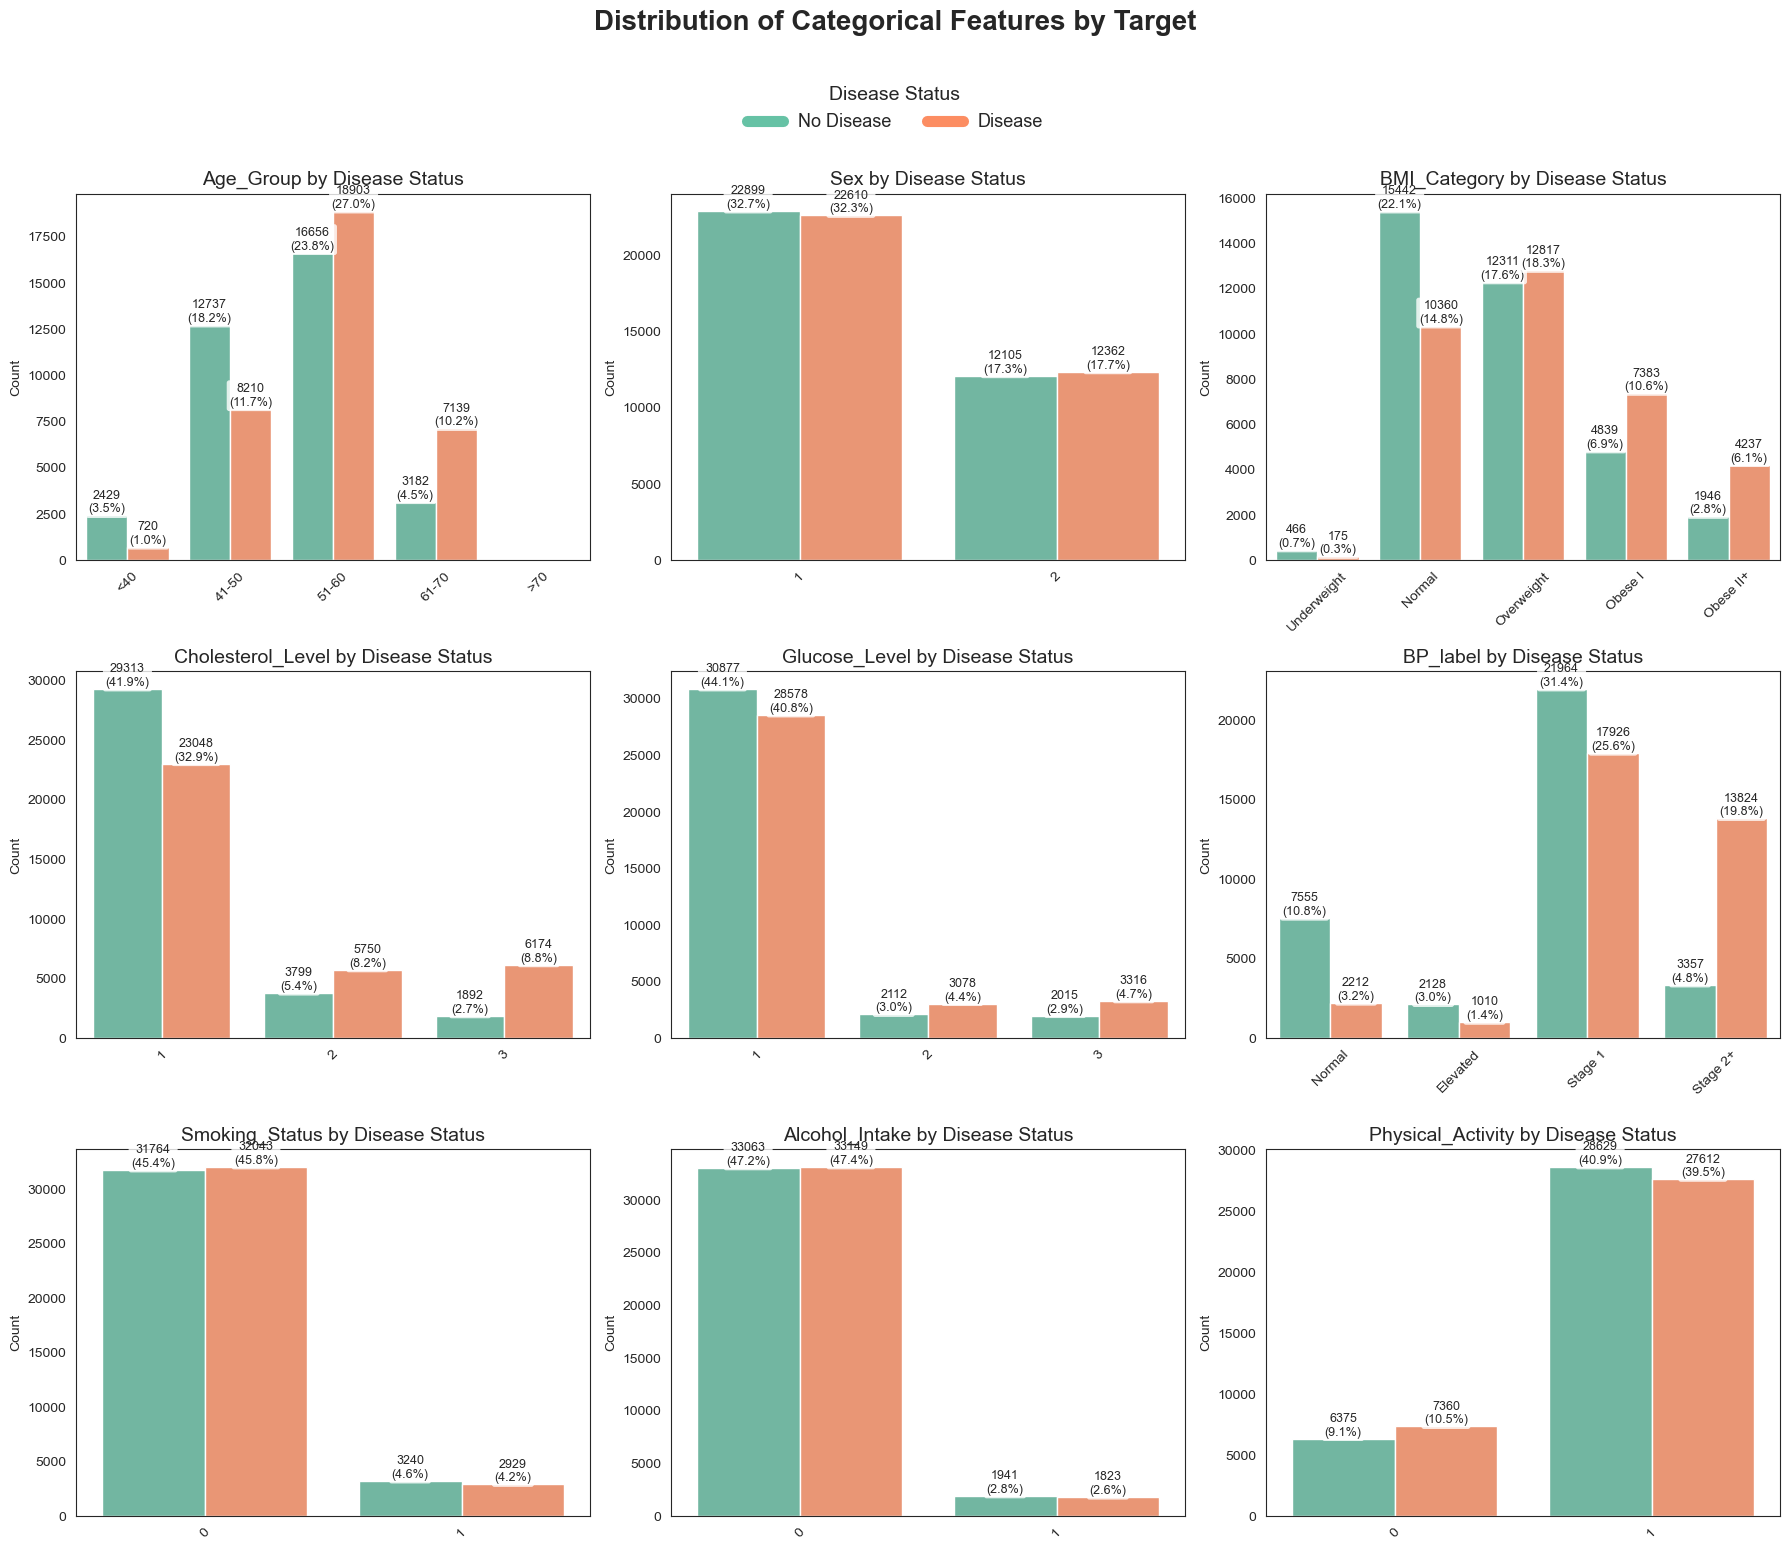

In [23]:
# ======================================================================
# Distribution of Categorical Features by Target
# ======================================================================
# --- Categorical features ---
cat_cols = [
    'Age_Group', 'Sex', 'BMI_Category', 'Cholesterol_Level', 'Glucose_Level',
    'BP_label', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity'
]

# --- Layout setup ---
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
sns.set_style("whitegrid")
axes = axes.flatten()

fig.suptitle('Distribution of Categorical Features by Target',
             fontsize=20, weight='bold', y=1.03)

# --- Plot each categorical variable ---
for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame")
        continue
        
    plot_df = df[[col, 'target']].copy().dropna()
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    
    # Ensure categorical type is handled
    if pd.api.types.is_categorical_dtype(plot_df[col]):
        categories = list(plot_df[col].cat.categories)
    else:
        categories = list(plot_df[col].unique())
        
    if pd.api.types.is_numeric_dtype(plot_df[col]) and not pd.api.types.is_categorical_dtype(plot_df[col]):
        plot_df[col] = plot_df[col].astype(str)

    sns_plot = sns.countplot(
        data=plot_df,
        x=col,
        hue='target_name',
        palette='Set2',
        ax=ax,
        dodge=True,
        legend=False
    )
    
    value_counts = plot_df[col].value_counts()
    
    for p in ax.patches:
        height = p.get_height()
        if height <= 0:
            continue
        x_pos = p.get_x() + p.get_width() / 2
        cat_name = p.get_x()
        percentage = f'{(height/value_counts.sum())*100:.1f}%'
        ax.text(x_pos, height + 0.1,
                f'{int(height)}\n({percentage})',
                ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='none'))

    ax.set_title(f'{col} by Disease Status', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# --- Hide unused axes ---
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# --- Legend ---
handles = [
    Line2D([0], [0], color=sns.color_palette('Set2')[0], lw=8, label='No Disease'),
    Line2D([0], [0], color=sns.color_palette('Set2')[1], lw=8, label='Disease')
]
fig.legend(
    handles=handles,
    labels=['No Disease', 'Disease'],
    title='Disease Status',
    loc='upper center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=2,
    frameon=False,
    fontsize=13,
    title_fontsize=14
)

# ======================================================================
# Correct Path Handling (Stable for all environments)
# ======================================================================
CURRENT_DIR = Path.cwd()

# If currently in /project/src or any subfolder of it, move up one level
if CURRENT_DIR.name.lower() == 'src' or 'src' in [p.name.lower() for p in CURRENT_DIR.parents]:
    for parent in CURRENT_DIR.parents:
        if parent.name.lower() == 'src':
            PROJECT_ROOT = parent.parent
            break
    else:
        PROJECT_ROOT = CURRENT_DIR
else:
    PROJECT_ROOT = CURRENT_DIR

# Define unified, correct visualization path
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Using folder: {PLOT_DIR.resolve()}")

# Define image path
img_path = PLOT_DIR / '01_Categorical_Distributions_by_Target.png'

# Overwrite if already exists
if img_path.exists():
    img_path.unlink()

try:
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {e}")

plt.show()

### ***Observations:***

***Strongest Factors Linked to Target 1:***

These are the conditions where individuals are much more likely to be in the Target 1 (orange) group:

* **Older Age:** The chances of being in Target 1 increase significantly with age.

* **High Blood Pressure:** This is the strongest indicator. Anyone in a hypertension category is overwhelmingly in Target 1.

* **High BMI:** Being overweight or obese is strongly associated with Target 1.

* **High Cholesterol & Glucose:** Elevated levels of both are clear indicators for Target 1.

* **Physical Inactivity:** A lack of physical activity shows a very strong link to Target 1.

***Factors with No Clear Link:***

These characteristics do not appear to be useful for predicting the target variable based on this data:

* **Smoking Status:** Smokers and non-smokers have a nearly identical split between Target 0 and Target 1.

* **Alcohol Intake:** Similar to smoking, this habit shows no connection to the target.

* **Sex:** The distribution between Target 0 and 1 is roughly the same for both sexes.

**Distribution:**
* target is roughly balanced 
* rest most the features are imbalanced

### -> Clinical_biomarkers


✅ Mapping verification:
BP_label unique values → ['Stage 1', 'Stage 2+', 'Normal', 'Elevated']
Glucose_Level unique values → ['Normal', 'Above Normal', 'Well Above Normal']
Cholesterol_Level unique values → ['Normal', 'Well Above Normal', 'Above Normal']
[INFO] Using folder: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis


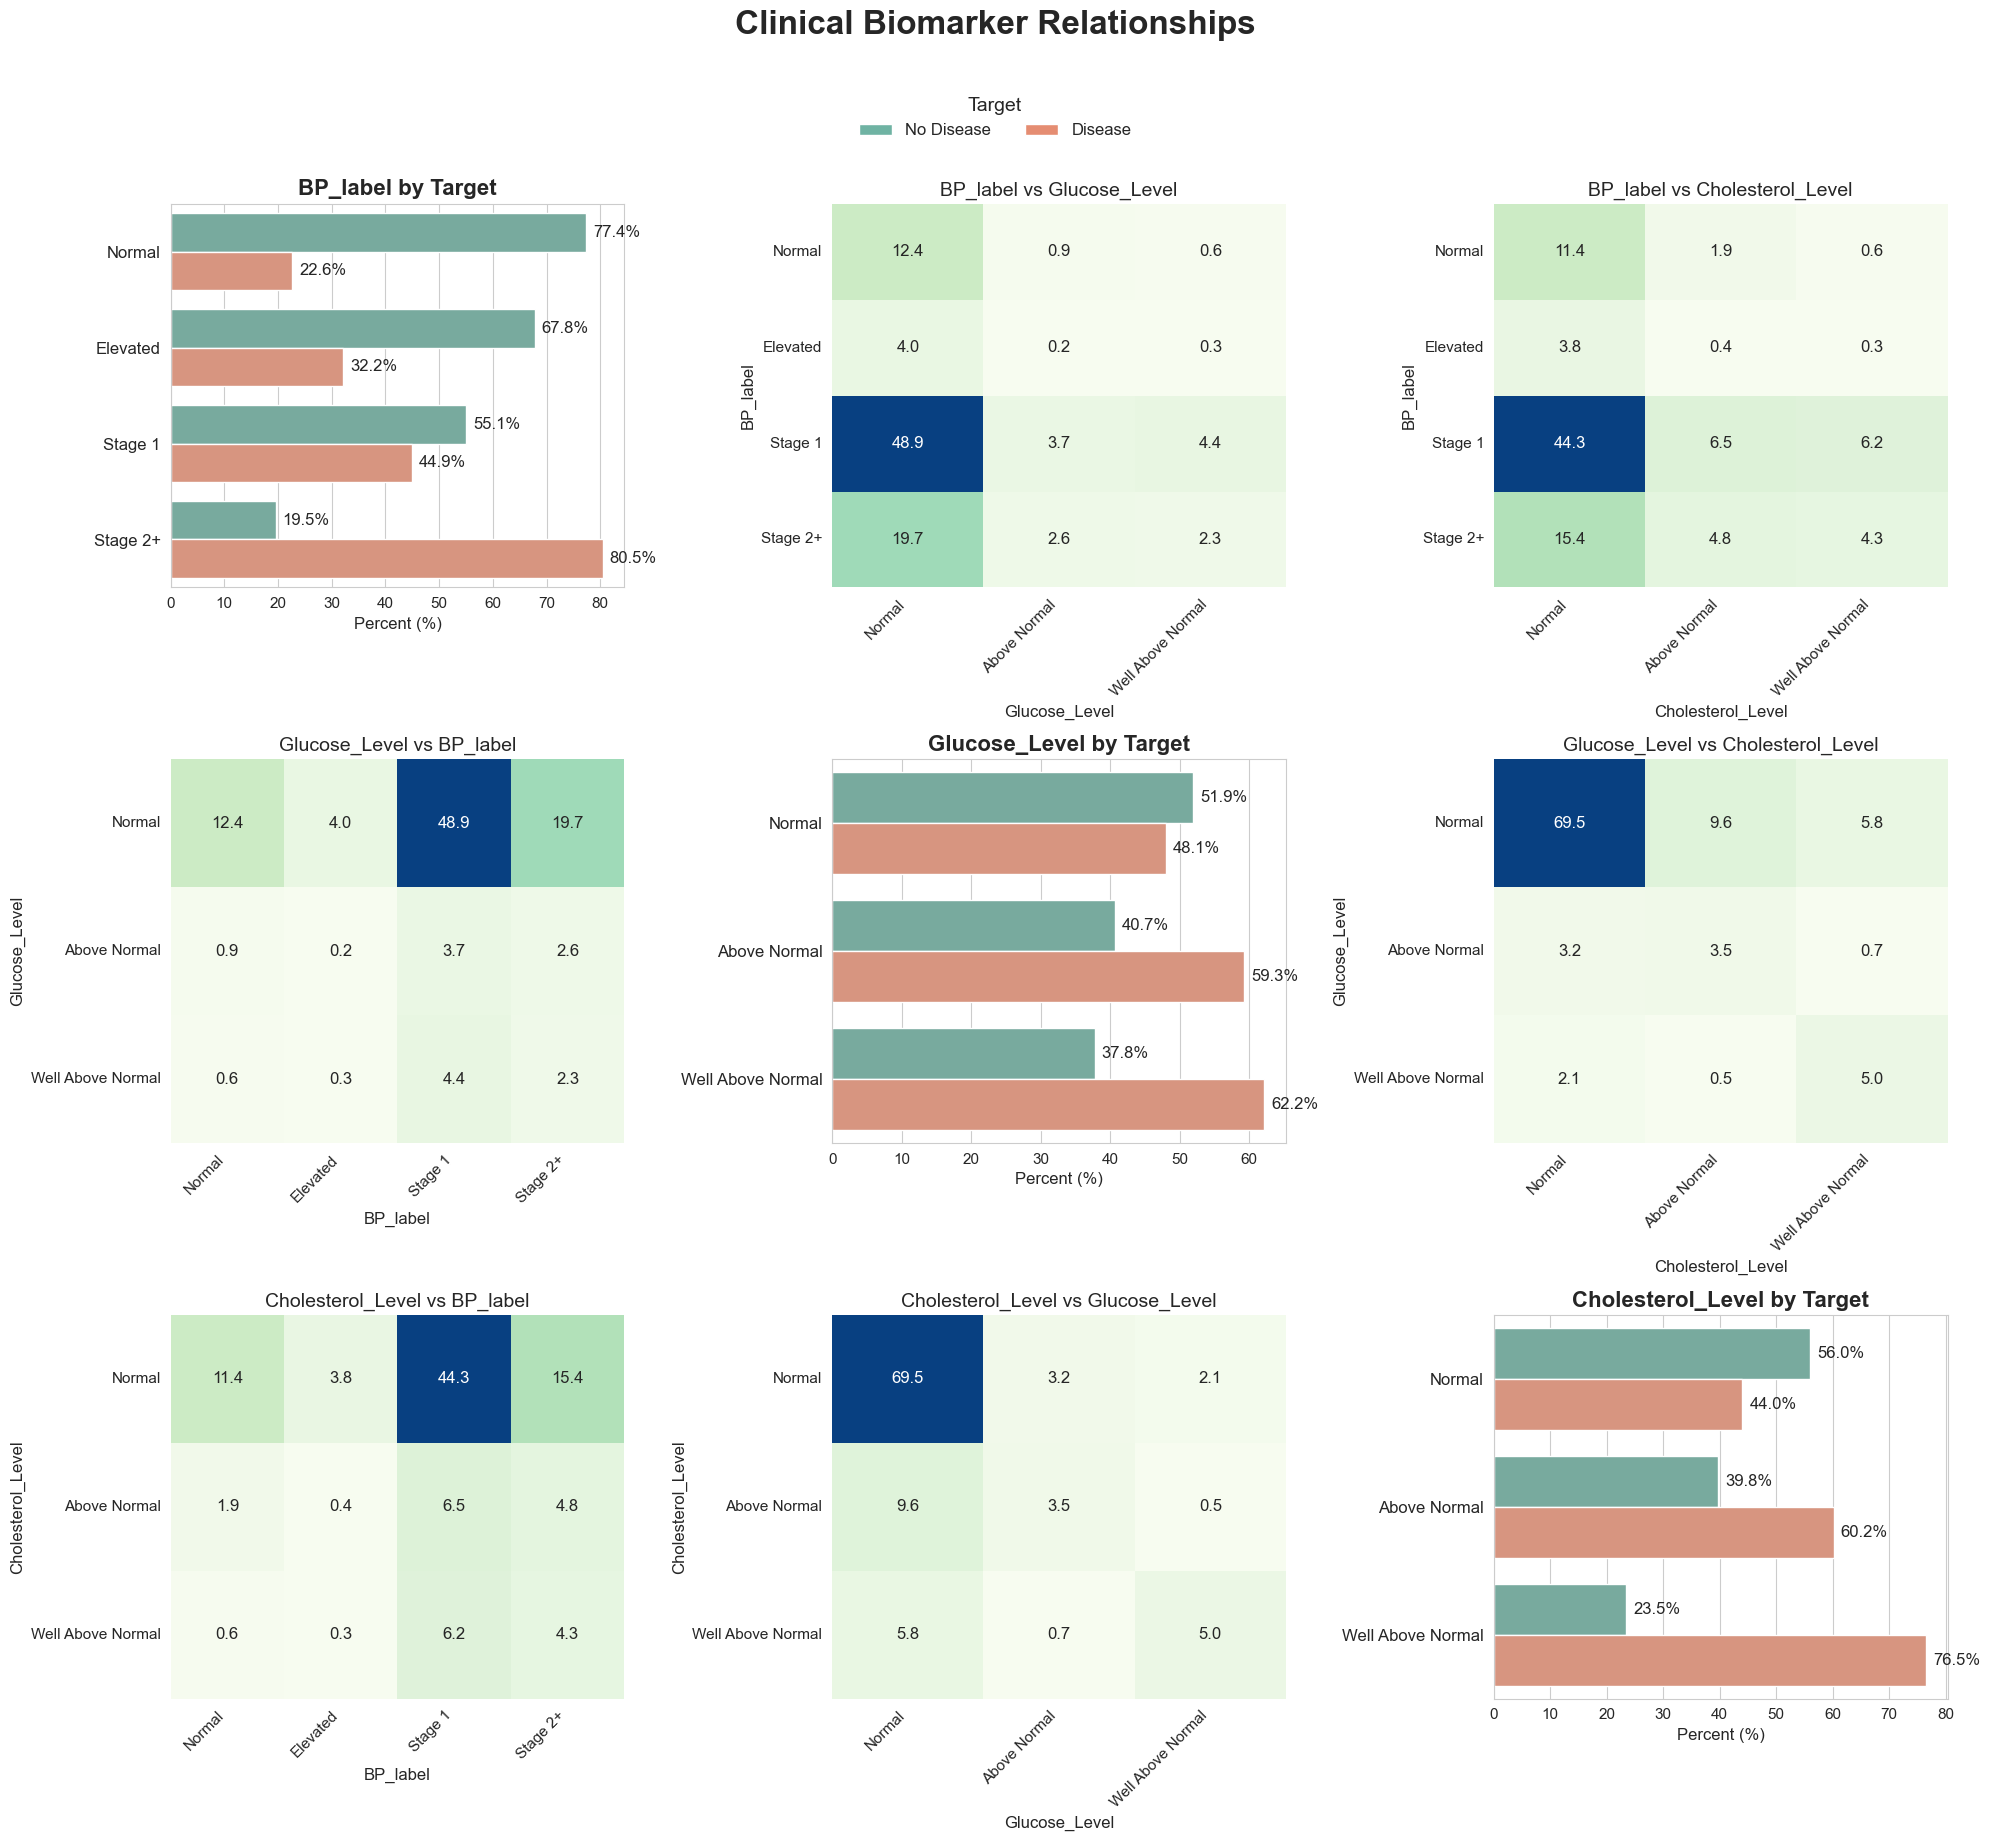

[SUCCESS] Plot successfully saved to: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis\02_Clinical_Biomarker_Relationships.png


In [24]:
# ============================================================
# Clinical Biomarker Relationships: Complete Code
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

# ---------------------------
# Project root
# ---------------------------
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR

# Move one level above if inside or below 'src'
for parent in CURRENT_DIR.parents:
    if parent.name.lower() == 'src':
        PROJECT_ROOT = parent.parent
        break

# ---------------------------
# Mapping dictionaries
# ---------------------------
bp_map = {1: 'Normal', 2: 'Elevated', 3: 'Stage 1', 4: 'Stage 2+'}
glucose_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}
cholesterol_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}

# ---------------------------
# Helper function to clean & map
# ---------------------------
def clean_and_map(df, col, mapping, new_col=None):
    if col not in df.columns:
        print(f"⚠️ Column not found: {col}")
        return df
    if df[col].dtype == 'object':
        mapped = df[col].map(mapping)
    else:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .replace({'nan': np.nan, 'None': np.nan, '': np.nan})
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')
        mapped = df[col].map(mapping)
    if new_col:
        df[new_col] = mapped
    else:
        df[col] = mapped
    return df

# ---------------------------
# Apply mappings
# ---------------------------
# Ensure BP_label exists
if 'BP_label' not in df.columns:
    if 'BP_level' in df.columns:
        df = clean_and_map(df, 'BP_level', bp_map, new_col='BP_label')
    else:
        print("❌ Neither BP_label nor BP_level found in DataFrame.")

# Always map glucose and cholesterol
df = clean_and_map(df, 'Glucose_Level', glucose_map)
df = clean_and_map(df, 'Cholesterol_Level', cholesterol_map)

# ---------------------------
# Verify mappings
# ---------------------------
print("\n✅ Mapping verification:")
for col in ['BP_label', 'Glucose_Level', 'Cholesterol_Level']:
    if col in df.columns:
        unique_vals = df[col].dropna().unique().tolist()
        print(f"{col} unique values → {unique_vals}")

# ---------------------------
# Prepare plotting
# ---------------------------
clinical_biomarkers = ['BP_label', 'Glucose_Level', 'Cholesterol_Level']

# target label
if 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#6fb3a3', 'Disease': '#e58d72'}
target_labels = list(TARGET_PALETTE.keys())

# Category orders
category_orders = {
    'BP_label': ['Normal', 'Elevated', 'Stage 1', 'Stage 2+'],
    'Glucose_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
    'Cholesterol_Level': ['Normal', 'Above Normal', 'Well Above Normal']
}

for col, order in category_orders.items():
    if col in df.columns:
        df[col] = pd.Categorical(df[col], categories=order, ordered=True)

# ---------------------------
# Directory to save plots
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Using folder: {PLOT_DIR.resolve()}")

# ---------------------------
# Figure layout
# ---------------------------
n = len(clinical_biomarkers)
fig, axes = plt.subplots(n, n, figsize=(20, 18), squeeze=False)

# ---------------------------
# Plot each combination
# ---------------------------
for i, row_feat in enumerate(clinical_biomarkers):
    for j, col_feat in enumerate(clinical_biomarkers):
        ax = axes[i, j]

        # Diagonal: grouped barplot
        if i == j:
            ct = pd.crosstab(df[row_feat], df['target_name'], normalize='index') * 100
            ct = ct.reset_index().melt(id_vars=row_feat, var_name='target_name', value_name='percent')

            sns.barplot(
                data=ct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, orient='h'
            )
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', fontsize=12, padding=5)

            ax.set_title(f'{row_feat} by Target', fontsize=16, weight='bold')
            ax.set_xlabel('Percent (%)', fontsize=12)
            ax.set_ylabel('')
            ax.tick_params(axis='x', labelsize=11)
            ax.tick_params(axis='y', labelsize=12)
            if ax.get_legend():
                ax.get_legend().remove()

        # Off-diagonal: joint heatmap
        else:
            if df[row_feat].notna().any() and df[col_feat].notna().any():
                ct = pd.crosstab(df[row_feat], df[col_feat])
                ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]
                if not ct.empty:
                    ct_pct = ct / ct.values.sum() * 100
                    sns.heatmap(
                        ct_pct, annot=True, fmt='.1f', cmap='GnBu',
                        cbar=False, ax=ax, annot_kws={"fontsize": 12}
                    )
                    ax.set_title(f'{row_feat} vs {col_feat}', fontsize=14)
                    ax.set_ylabel(row_feat, fontsize=12)
                    ax.set_xlabel(col_feat, fontsize=12)
                    ax.tick_params(axis='x', labelsize=11, rotation=45)
                    ax.tick_params(axis='y', labelsize=11, rotation=0)
                    for label in ax.get_xticklabels():
                        label.set_horizontalalignment('right')
                else:
                    ax.axis('off')
                    ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=16, color='gray', transform=ax.transAxes)
            else:
                ax.axis('off')
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=16, color='gray', transform=ax.transAxes)

# ---------------------------
# Final layout & legend
# ---------------------------
fig.suptitle('Clinical Biomarker Relationships', fontsize=24, weight='bold', y=1.02)
handles = [Patch(facecolor=color, label=label) for label, color in TARGET_PALETTE.items()]
fig.legend(
    handles=handles, title='Target', title_fontsize=14, fontsize=12,
    loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=len(target_labels), frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# ---------------------------
# Save & display
# ---------------------------
img_path = PLOT_DIR / '02_Clinical_Biomarker_Relationships.png'
if img_path.exists():
    img_path.unlink()

plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"[SUCCESS] Plot successfully saved to: {img_path.resolve()}")

# Cleanup temporary column
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

### **Observations**


### **Blood Pressure (BP)**

* **Higher BP = Higher Disease Risk:** The risk is strongest here. People with **Stage 2+** BP have an **80.5%** chance of disease, which is over 3.5 times higher than those with Normal BP.
* **Most Common Group:** A lot of people in this dataset have **Stage 1 Hypertension** but with normal glucose and cholesterol levels.

### **Cholesterol**

* **Higher Cholesterol = Higher Disease Risk:** The disease risk jumps from **44.0%** for normal cholesterol to **76.5%** for the highest level.
* **Most Common Mix:** The single largest group of people have **Stage 1 Hypertension + Normal Cholesterol**.

### **Glucose**

* **Higher Glucose = Higher Disease Risk:** The chance of disease goes up from **48.1%** for normal glucose to **62.2%** for the highest level.
* **Most Common Mix:** The second most common group have **Stage 1 Hypertension + Normal Glucose**.

In [25]:
# --- Define features and category orders ---
clinical_biomarkers = ['Cholesterol_Level', 'Glucose_Level', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure']
target_col = 'target'

category_orders = {
    'Cholesterol_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
    'Glucose_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
}

# --- Map integer codes to string labels ---
chol_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}
gluc_map = {1: 'Normal', 3: 'Well Above Normal', 2: 'Above Normal'}  # Note: Changed order to match data

# --- Apply mappings with validation ---
if pd.api.types.is_numeric_dtype(df['Cholesterol_Level']):
    df['Cholesterol_Level'] = df['Cholesterol_Level'].map(chol_map)
if pd.api.types.is_numeric_dtype(df['Glucose_Level']):
    df['Glucose_Level'] = df['Glucose_Level'].map(gluc_map)

# --- Convert to categorical with proper ordering ---
for col, order in category_orders.items():
    if col in df.columns:
        df[col] = pd.Categorical(df[col], categories=order, ordered=True)

results = []
for col in clinical_biomarkers:
    if col not in df.columns:
        print(f"Skipping '{col}' because it is not in the DataFrame.")
        continue
        
    valid = df[[col, target_col]].dropna()
    if valid.empty:
        print(f"Skipping '{col}' due to all values missing after dropna.")
        continue
        
    ct = pd.crosstab(valid[col], valid[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue

    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0

    direction = None
    if 1 in ct.columns:
        rates = ct.div(ct.sum(axis=1), axis=0)[1]
        if not rates.empty and len(rates) > 1 and not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"

    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

,Feature,Chi2_p,CramersV,Direction
0,Cholesterol_Level,0.000000e+00,0.221120,positive
1,Glucose_Level,5.150929e-128,0.091526,positive
2,Systolic_BP,0.000000e+00,0.470967,positive
3,Diastolic_BP,0.000000e+00,0.379431,positive
4,Pulse_Pressure,0.000000e+00,0.374103,positive


### ***Observations:***
* **All three factors matter:** High blood pressure, high cholesterol, and high glucose all increase the risk of the disease.
* **Blood Pressure is the biggest risk:** It has the strongest link to the disease. The risk is over 3.5 times higher for people with the highest BP compared to normal.
* **Cholesterol is a medium risk:** It's the second most important factor.
* **Glucose is the smallest risk:** It has the weakest connection to the disease of the three.
* **Common Profile:** Many people in the study have Stage 1 High Blood Pressure but normal cholesterol and glucose levels. This suggests high BP is often the first warning sign.

### -> Demographics

[INFO] Using folder: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis


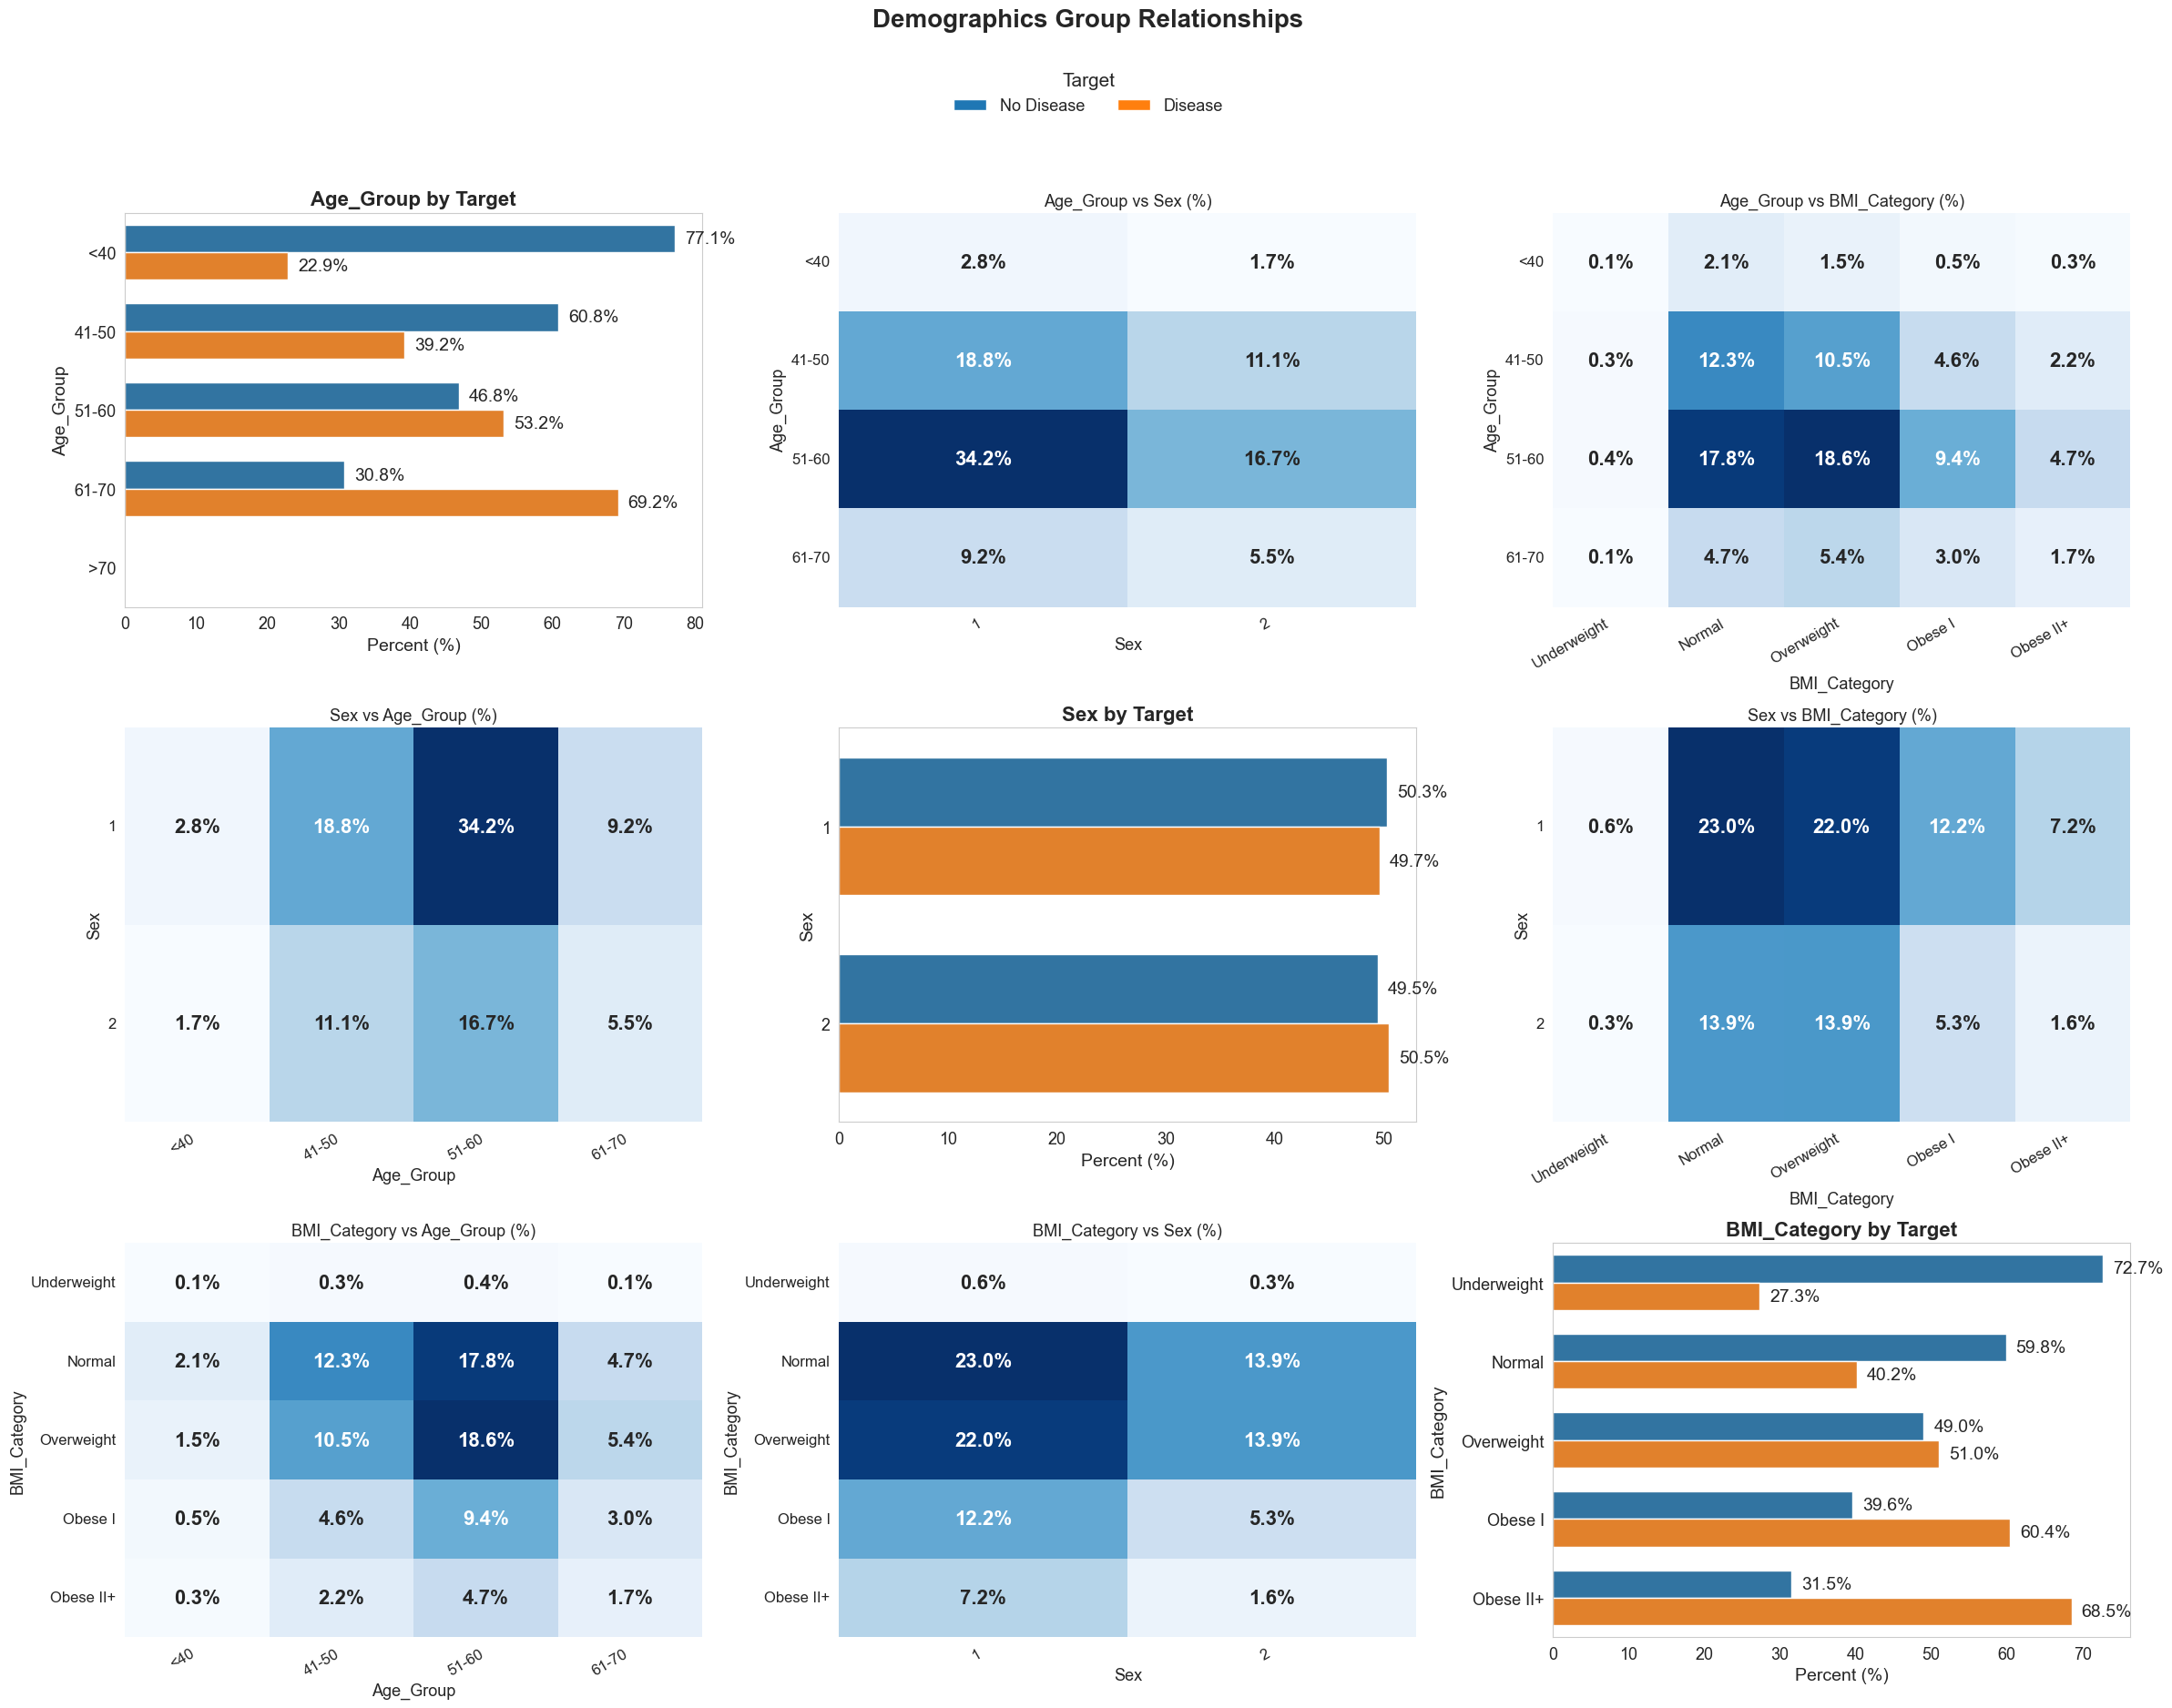

[SUCCESS] Plot saved at: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis\03_Demographics_Group_Relationships.png


In [26]:
# ============================================================
# Demographics Group Relationships Plot
# ============================================================

# Demographic features
demographics = ['Age_Group', 'Sex', 'BMI_Category']

# ---------------------------
# Ensure target_name exists
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}
target_labels = list(TARGET_PALETTE.keys())
n = len(demographics)

# ---------------------------
# Robust project root detection (outside src)
# ---------------------------
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR

# If inside or below 'src', move exactly one level above
for parent in CURRENT_DIR.parents:
    if parent.name.lower() == 'src':
        PROJECT_ROOT = parent.parent
        break

# ---------------------------
# Folder path (spaces only)
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Using folder: {PLOT_DIR.resolve()}")

# ---------------------------
# Figure layout
# ---------------------------
fig, axes = plt.subplots(n, n, figsize=(8*n, 6*n), squeeze=False)

# ---------------------------
# Plotting
# ---------------------------
for i, row_feat in enumerate(demographics):
    for j, col_feat in enumerate(demographics):
        ax = axes[i, j]
        if i == j:
            # Diagonal: Grouped barplot by target (% labels)
            ct = pd.crosstab(df[row_feat], df['target_name'])
            ct = ct.loc[ct.sum(axis=1) > 0]  # remove empty rows
            ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
            ct_pct = ct_pct.reset_index().melt(
                id_vars=row_feat, var_name='target_name', value_name='percent'
            )

            sns.barplot(
                data=ct_pct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, dodge=True, width=0.7,
                orient='h', legend=False
            )
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', fontsize=14, padding=8, label_type='edge')

            ax.set_ylabel(row_feat, fontsize=14)
            ax.set_xlabel('Percent (%)', fontsize=14)
            ax.set_title(f'{row_feat} by Target', fontsize=16, weight='bold')
            ax.grid(False)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=13)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)

        else:
            # Off-diagonal: Heatmap of joint distribution (% of total)
            ct = pd.crosstab(df[row_feat], df[col_feat])
            ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]  # remove empty bins
            if ct.shape[0] > 0 and ct.shape[1] > 0:
                ct_pct = ct / ct.values.sum() * 100
                hm = sns.heatmap(
                    ct_pct, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax,
                    annot_kws={"fontsize": 16, "fontweight": "bold"}
                )
                for text in hm.texts:
                    text.set_text(f"{text.get_text()}%")
                ax.set_xlabel(col_feat, fontsize=13)
                ax.set_ylabel(row_feat, fontsize=13)
                ax.set_title(f'{row_feat} vs {col_feat} (%)', fontsize=13)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
            else:
                ax.axis('off')

# ---------------------------
# Main title and legend
# ---------------------------
fig.suptitle('Demographics Group Relationships', fontsize=20, weight='bold', y=1.04)
handles = [Patch(facecolor=TARGET_PALETTE[name], label=name) for name in target_labels]
fig.legend(
    handles=handles, labels=target_labels, title='Target', title_fontsize=15, fontsize=13,
    loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(target_labels), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# ---------------------------
# Save figure
# ---------------------------
img_path = PLOT_DIR / '03_Demographics_Group_Relationships.png'

# Overwrite if exists
if img_path.exists():
    img_path.unlink()

plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()

print(f"[SUCCESS] Plot saved at: {img_path.resolve()}")

# ---------------------------
# Cleanup
# ---------------------------
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

***Observations:***

* **Age is a Major Factor:**
    * The older the group, the higher the disease risk.
    * The chance of disease **triples**, rising from **22.3%** for the youngest group (`<40`) to **69.2%** for the oldest group (`61-70`).
    * Most people in the study are in the **'51-60'** age bracket.

* **BMI Shows a Clear Trend:**
    * **Higher BMI means higher disease risk.**
    * The risk starts low at **27.3%** for the 'Underweight' group and steadily climbs to **68.5%** for the 'Obese II+' group. The 'Normal' weight group has a **40.1%** disease rate.
    * Most people in their 50s have a **'Normal'** or **'Overweight'** BMI.

* **Sex is Not a Factor:**
    * The disease risk is almost identical for both sexes (around **49.5%**).
    * However, the study includes more people from **Sex '1'** than **Sex '2'**, especially in the older age groups.

In [27]:
# Ensure correct columns exist and are not mislabelled
expected_demographics = ['Age_Group', 'Sex', 'BMI_Category']
for col in expected_demographics:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame. Check column names and feature engineering steps.")

# Ensure correct dtype for each demographic variable
if not pd.api.types.is_categorical_dtype(df['Age_Group']):
    df['Age_Group'] = df['Age_Group'].astype('category')
if not pd.api.types.is_categorical_dtype(df['BMI_Category']):
    df['BMI_Category'] = df['BMI_Category'].astype('category')
if not pd.api.types.is_categorical_dtype(df['Sex']):
    df['Sex'] = df['Sex'].astype('category')

demographics = ['Age_Group', 'Sex', 'BMI_Category']
target_col = 'target'

results = []
for col in demographics:
    ct = pd.crosstab(df[col], df[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue
    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0
    # Direction: difference in disease rate between highest and lowest category
    rates = ct.div(ct.sum(axis=1), axis=0)[1] if 1 in ct.columns else None
    direction = None
    if rates is not None and len(rates) > 1:
        if not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"
    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1600276651.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['Age_Group']):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1600276651.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['BMI_Category']):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1600276651.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['Sex']):


,Feature,Chi2_p,CramersV,Direction
0,Age_Group,0.000000,0.225710,positive
1,Sex,0.034164,0.008007,positive
2,BMI_Category,0.000000,0.189832,positive


### ***Observations:***

* **Age: The Strongest Demographic Factor**
    **age is the most important predictor** in this group. The statistical table confirms this with the highest association score (**Cramer's V = 0.23**). The disease risk climbs steadily with age, starting at **22.3%** for those under 40 and rising to **69.2%** for the 61-70 age group.

* **BMI: Also a Strong Factor**
    **BMI is the second most significant risk factor** (**Cramer's V = 0.19**). There is a clear positive correlation where higher BMI is linked to higher disease risk. The rate increases from **27.3%** for the 'Underweight' category to **68.5%** for the 'Obese II+' category.

* **Sex: Not a Significant Factor**
    The statistical table shows that **sex has a negligible association** with the disease (**Cramer's V = 0.008**). This is supported by the chart, where the disease rates are nearly identical for both sexes (**~49.5%**).

### -> Lifestyle

[INFO] Using folder: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis


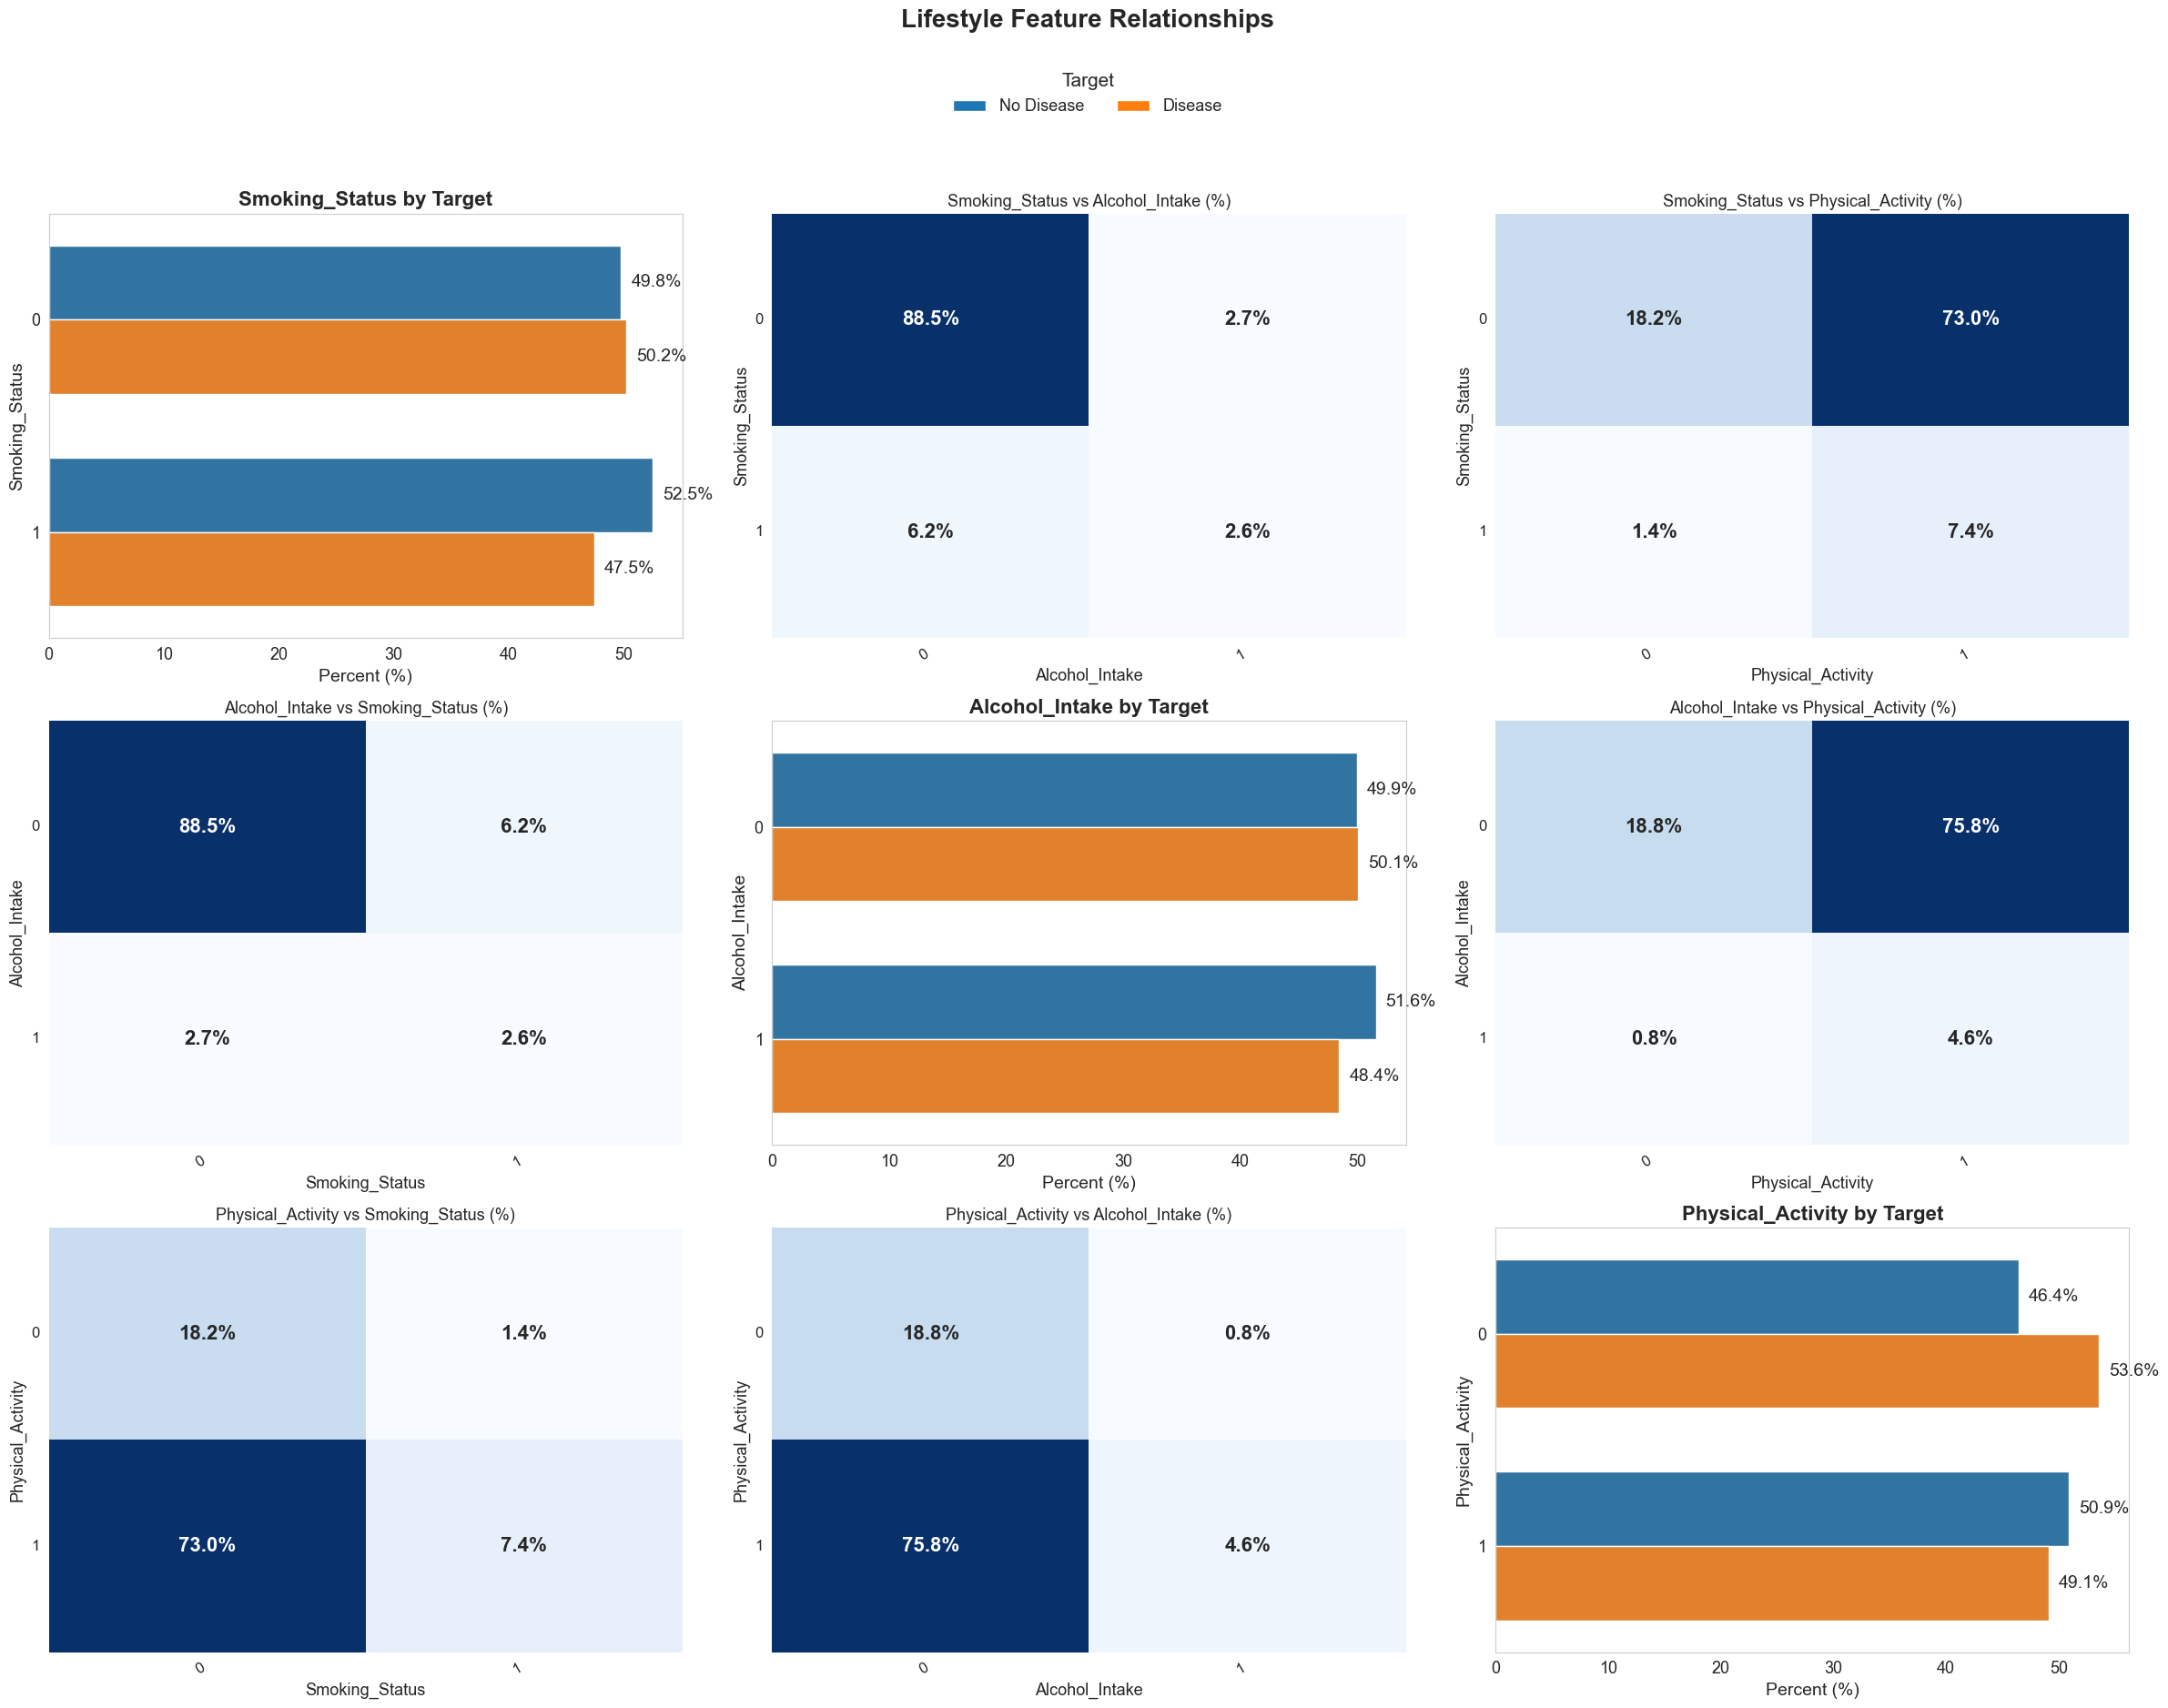

[SUCCESS] Plot saved at: P:\projects\heart_disease_prediction\reports\visualizations\univariate analysis\categorical analysis\04_Lifestyle_Feature_Relationships.png


In [28]:
# ============================================================
# Lifestyle Feature Relationships Plot
# ============================================================
# Lifestyle features
lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

# ---------------------------
# Ensure target_name exists
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}
target_labels = list(TARGET_PALETTE.keys())
n = len(lifestyle)

# ---------------------------
# Robust project root detection (outside src)
# ---------------------------
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR
for parent in CURRENT_DIR.parents:
    if parent.name.lower() == 'src':
        PROJECT_ROOT = parent.parent
        break

# ---------------------------
# Folder path (spaces only)
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Using folder: {PLOT_DIR.resolve()}")

# ---------------------------
# Figure layout
# ---------------------------
fig, axes = plt.subplots(n, n, figsize=(8*n, 6*n), squeeze=False)

# ---------------------------
# Plotting
# ---------------------------
for i, row_feat in enumerate(lifestyle):
    for j, col_feat in enumerate(lifestyle):
        ax = axes[i, j]
        if i == j:
            # Diagonal: Grouped barplot by target (% labels)
            ct = pd.crosstab(df[row_feat], df['target_name'])
            ct = ct.loc[ct.sum(axis=1) > 0]  # remove empty rows
            ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
            ct_pct = ct_pct.reset_index().melt(id_vars=row_feat, var_name='target_name', value_name='percent')

            sns.barplot(
                data=ct_pct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, dodge=True, width=0.7, orient='h', legend=False
            )
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', fontsize=14, padding=8, label_type='edge')

            ax.set_ylabel(row_feat, fontsize=14)
            ax.set_xlabel('Percent (%)', fontsize=14)
            ax.set_title(f'{row_feat} by Target', fontsize=16, weight='bold')
            ax.grid(False)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=13)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)

        else:
            # Off-diagonal: Heatmap of joint distribution (% of total)
            ct = pd.crosstab(df[row_feat], df[col_feat])
            ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]
            if not ct.empty:
                ct_pct = ct / ct.values.sum() * 100
                hm = sns.heatmap(
                    ct_pct, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax,
                    annot_kws={"fontsize": 16, "fontweight": "bold"}
                )
                for text in hm.texts:
                    text.set_text(f"{text.get_text()}%")
                ax.set_xlabel(col_feat, fontsize=13)
                ax.set_ylabel(row_feat, fontsize=13)
                ax.set_title(f'{row_feat} vs {col_feat} (%)', fontsize=13)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
            else:
                ax.axis('off')

# ---------------------------
# Main title and legend
# ---------------------------
fig.suptitle('Lifestyle Feature Relationships', fontsize=20, weight='bold', y=1.04)
handles = [Patch(facecolor=TARGET_PALETTE[name], label=name) for name in target_labels]
fig.legend(
    handles=handles, labels=target_labels, title='Target', title_fontsize=15, fontsize=13,
    loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(target_labels), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# ---------------------------
# Save figure robustly
# ---------------------------
img_path = PLOT_DIR / '04_Lifestyle_Feature_Relationships.png'
if img_path.exists():
    img_path.unlink()  # overwrite existing file

plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"[SUCCESS] Plot saved at: {img_path.resolve()}")

# ---------------------------
# Cleanup
# ---------------------------
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

#### **1. Smoking Status**
* **Disease Risk:** Smoking status **doesn't seem to matter** for disease risk. The chances are about 50/50 for both groups.
* **Population Habits:** The heatmaps show that the vast majority of people are non-smokers. The most common profile is a **non-smoker who is physically active (73%)**.

#### **2. Alcohol Intake**
* **Disease Risk:** Similar to smoking, alcohol intake shows **no real link** to the disease. The risk is about 50/50 whether a person drinks or not.
* **Population Habits:** The heatmaps reveal that most people are non-drinkers. In fact, nearly 9 out of 10 people (**88.5%**) are in the same **non-smoking, non-drinking** category.

#### **3. Physical Activity**
* **Disease Risk:** This is the only factor that makes a small difference. One activity group (likely the less active one) has a **slightly higher disease risk (54%)** than the other (49%).
* **Population Habits:** The heatmaps show that the most common person in this dataset is **physically active**, with over 75% of non-drinkers also being physically active.

In [29]:
# Ensure correct columns exist and are not mislabelled
expected_lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
for col in expected_lifestyle:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame. Check column names and feature engineering steps.")

# Ensure correct dtype for each lifestyle variable
for col in expected_lifestyle:
    if not pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].astype('category')

lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
target_col = 'target'

results = []
for col in lifestyle:
    ct = pd.crosstab(df[col], df[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue
    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0
    # Direction: difference in disease rate between highest and lowest category
    rates = ct.div(ct.sum(axis=1), axis=0)[1] if 1 in ct.columns else None
    direction = None
    if rates is not None and len(rates) > 1:
        if not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"
    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5688\1898225904.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[col]):


,Feature,Chi2_p,CramersV,Direction
0,Smoking_Status,4.209577e-05,0.015483,negative
1,Alcohol_Intake,5.340153e-02,0.007302,negative
2,Physical_Activity,4.291420e-21,0.035630,negative


### ***Observations:***

* **Physical Activity: A Very Weak Connection**
    
    **Physical Activity** has the strongest link, but it's still **very weak** overall. The data shows that people who are physically active have a slightly lower rate of disease (**49.1%**) compared to those who are not (**53.6%**).

*  **Smoking Status: An Extremely Weak Connection**
    Smoking shows a statistically significant but **practically tiny** relationship with the disease. The difference in disease rates between the two smoking groups is almost negligible (**50.2%** vs. **47.5%**).

* ***Alcohol Intake: No Significant Connection ***
    According to the statistics, **alcohol intake has no significant link** to the disease. The small difference seen in the chart is not statistically meaningful and is likely due to random chance.

### Multivariate Analysis

In [30]:
# Drop unwanted columns with errors='ignore' for robustness
df = df.drop(['BP_label','BP_LEVEL','Age_Group', 'BMI_Category' ], axis=1, errors='ignore')

In [31]:
# -----------------------------
# 1️ Identify numeric and categorical columns
# -----------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# -----------------------------
# 2️ Impute numeric columns with mean
# -----------------------------
if numeric_cols:
    num_imputer = SimpleImputer(strategy='mean')
    df[numeric_cols] = pd.DataFrame(
        num_imputer.fit_transform(df[numeric_cols]),
        columns=numeric_cols
    )

# -----------------------------
# 3️ Impute categorical columns with mode
# -----------------------------
if categorical_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = pd.DataFrame(
        cat_imputer.fit_transform(df[categorical_cols]),
        columns=categorical_cols
    )
    # Encode categorical columns numerically for Logistic Regression
    enc = OrdinalEncoder()
    df[categorical_cols] = enc.fit_transform(df[categorical_cols])

# -----------------------------
# 4️ Train Logistic Regression to get model weights
# -----------------------------
y = df['target']
X = df.drop(columns=['target'])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=1000))
])

pipeline.fit(X, y)

# -----------------------------
# 5️ Extract model weights (coefficients)
# -----------------------------
coefficients = pd.Series(pipeline.named_steps['clf'].coef_[0], index=X.columns)
coeff_df = coefficients.sort_values(key=abs, ascending=False).reset_index()
coeff_df.columns = ['Feature', 'Coefficient']

print("\n--- Model Weights (Coefficients) ---")
print(coeff_df.to_string(index=False))


--- Model Weights (Coefficients) ---
          Feature  Coefficient
      Systolic_BP     0.466133
     Diastolic_BP     0.399668
        Age_Years     0.361314
   Pulse_Pressure     0.347219
              BMI     0.179269
Cholesterol_Level     0.111692
Physical_Activity    -0.086952
   Alcohol_Intake    -0.035567
   Smoking_Status    -0.032201
    Glucose_Level    -0.019697
              Sex     0.004835
         BP_level    -0.001909


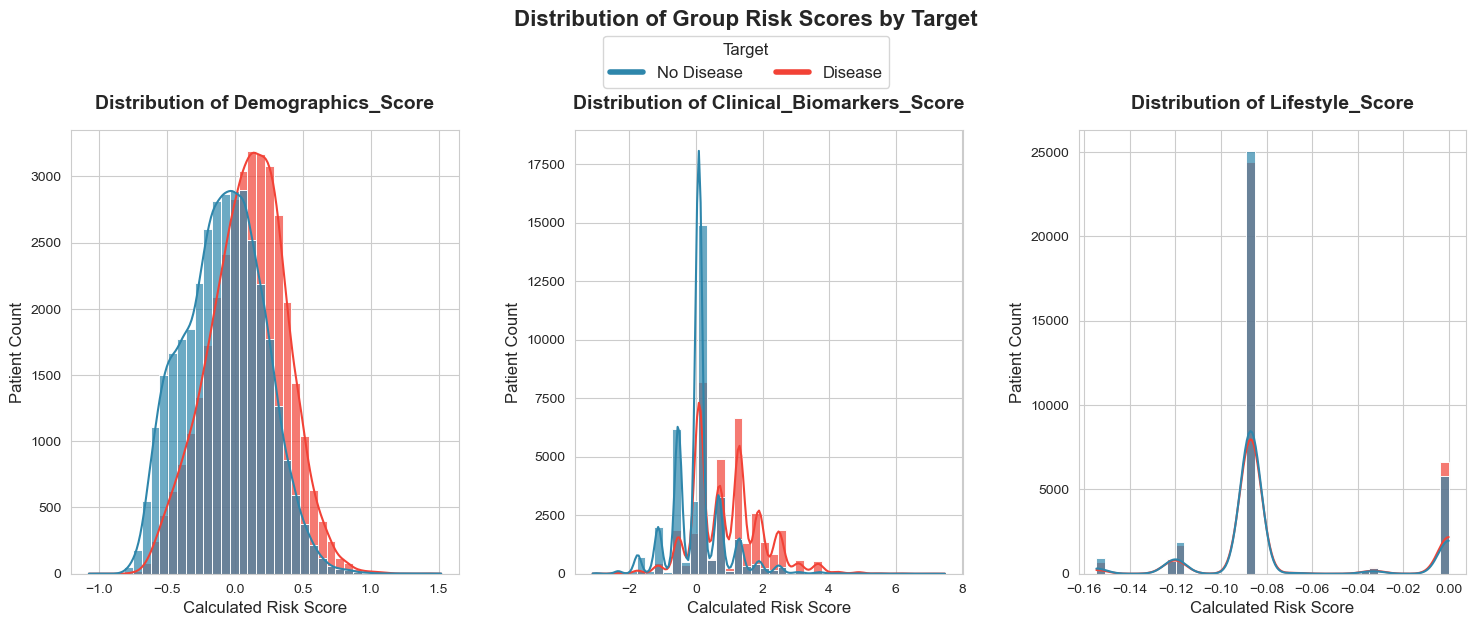

✅ Group risk scores calculated and visualized successfully!
📊 Added columns to original DataFrame: ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']


In [32]:
target_column = 'target'

# ---------------------------
# Groups and features
# ---------------------------
groups_by_original_features = {
    'Demographics_Score': ['Age_Years', 'Sex', 'BMI'],
    'Clinical_Biomarkers_Score': ['Cholesterol_Level', 'Glucose_Level', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure'],
    'Lifestyle_Score': ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
}

# ---------------------------
# Compute group scores using model coefficients directly on original df
# ---------------------------
for group_name, original_features_list in groups_by_original_features.items():
    # Keep only features present in coefficients
    group_cols = [c for c in original_features_list if c in coefficients.index]
    
    if group_cols:
        df[group_name] = df[group_cols].dot(coefficients[group_cols])
    else:
        df[group_name] = 0.0

# ---------------------------
# Convert target to string for plotting
# ---------------------------
df[target_column] = df[target_column].map({0: 'No Disease', 1: 'Disease'})

# ---------------------------
# Plot histograms
# ---------------------------
score_columns = list(groups_by_original_features.keys())
palette = {'No Disease': '#2E86AB', 'Disease': '#F24236'}

fig, axes = plt.subplots(1, len(score_columns), figsize=(6 * len(score_columns), 6), sharey=False)
if len(score_columns) == 1:
    axes = [axes]

for i, score_col in enumerate(score_columns):
    ax = axes[i]
    sns.histplot(
        data=df,
        x=score_col,
        hue=target_column,
        bins=40,
        palette=palette,
        kde=True,
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f'Distribution of {score_col}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Calculated Risk Score', fontsize=12)
    ax.set_ylabel('Patient Count', fontsize=12)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# ---------------------------
# Title + Shared Legend
# ---------------------------
fig.suptitle('Distribution of Group Risk Scores by Target', fontsize=16, fontweight='bold', y=1.05)

handles = [Line2D([0], [0], color=c, lw=4) for c in palette.values()]
labels = list(palette.keys())
fig.legend(handles, labels, title='Target', loc='upper center', ncol=2, frameon=True, fontsize=12, title_fontsize=12, bbox_to_anchor=(0.5, 1.02))

# Adjust layout
fig.subplots_adjust(top=0.85, wspace=0.3)

# Display plot (NO SAVING)
plt.show()

print("✅ Group risk scores calculated and visualized successfully!")
print(f"📊 Added columns to original DataFrame: {score_columns}")

* **`Clinical_Biomarkers_Score` (Primary Driver)**
    This score, composed of cardiovascular and metabolic indicators (BP, Cholesterol, Glucose), is the **strongest predictor** of the target. Higher scores are clearly associated with the "Disease" group, confirming that these vitals are the dominant drivers of the model.

* **`DemographicsScore` (Secondary Driver)**
    This score, combining Age, BMI, and Sex, is a **secondary contributor** to the overall risk. It shows a moderate positive correlation with the "Disease" group but is less influential than the Vitals score.

* **`Lifestyle_Score` (Confounding Factor)**
    This score shows a **counter-intuitive relationship** where lower (more protective) lifestyle scores are associated with the "Disease" group. This indicates a confounding effect: the at-risk population in this dataset has healthier lifestyle habits that are being overpowered by the significant negative impact of their poor vitals.

Project root: p:\projects\heart_disease_prediction
Artifacts directory: p:\projects\heart_disease_prediction\artifacts
Plots directory: p:\projects\heart_disease_prediction\reports\visualizations
✓ X_train.parquet saved/overwritten
✓ X_test.parquet saved/overwritten
✓ y_train.parquet saved/overwritten
✓ y_test.parquet saved/overwritten
✓ Plot saved/overwritten: p:\projects\heart_disease_prediction\reports\visualizations\multivariate analysis\02_Scaled_Scores_Distribution.png


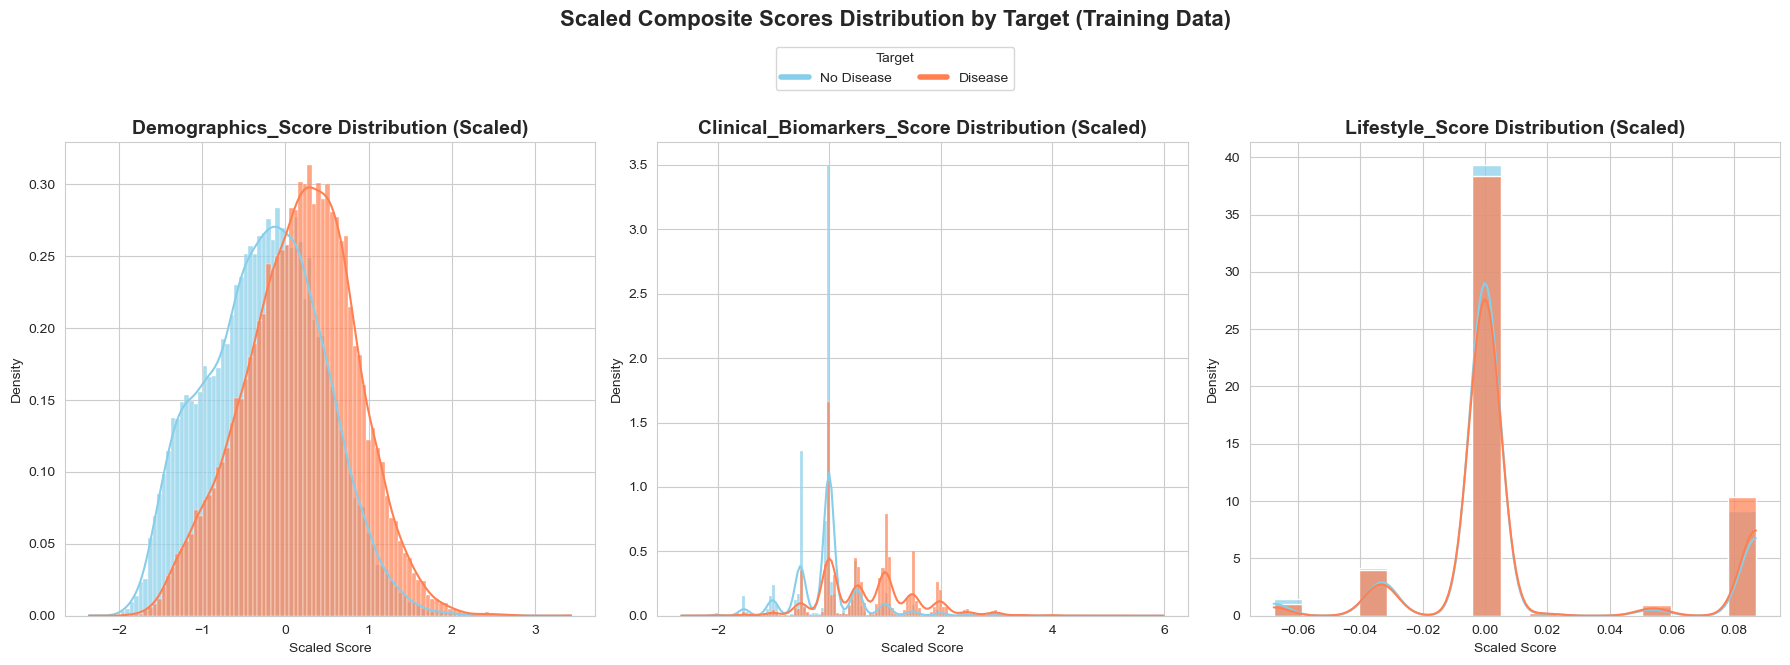

In [33]:
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# ==============================================================================
# PATH CONFIGURATION
# ==============================================================================

# Set project root - go up from notebooks directory to project root
PROJECT_ROOT = Path.cwd().parent.parent
DATA_DIR = PROJECT_ROOT / 'data'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations'

# Create directories if they don't exist (only creates if missing)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Artifacts directory: {ARTIFACTS_DIR}")
print(f"Plots directory: {PLOT_DIR}")

# ==============================================================================
# DATA SPLITTING AND SCALING FOR MODELING
# ==============================================================================

# Split the Data first (before any scaling)
X = df.drop('target', axis=1)
y = df['target']

# Ensure y is numeric for splitting
if y.dtype == object or str(y.dtype).startswith('category'):
    y = y.map({'No Disease': 0, 'Disease': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Reset indices to avoid alignment issues
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Scale Scores - Fit on train, transform both
score_features = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
scaler = RobustScaler()

# Create copies to avoid modifying original data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit ONLY on training data
scaler.fit(X_train_scaled[score_features])

# Transform both train and test
X_train_scaled[score_features] = scaler.transform(X_train_scaled[score_features])
X_test_scaled[score_features] = scaler.transform(X_test_scaled[score_features])

# Save the processed data to artifacts folder (ALWAYS overwrite)
X_train_scaled.to_parquet(ARTIFACTS_DIR / 'X_train.parquet')
print("✓ X_train.parquet saved/overwritten")

X_test_scaled.to_parquet(ARTIFACTS_DIR / 'X_test.parquet')
print("✓ X_test.parquet saved/overwritten")

y_train.to_frame(name='target').to_parquet(ARTIFACTS_DIR / 'y_train.parquet')
print("✓ y_train.parquet saved/overwritten")

y_test.to_frame(name='target').to_parquet(ARTIFACTS_DIR / 'y_test.parquet')
print("✓ y_test.parquet saved/overwritten")

# ==============================================================================
# Create Distribution Plots for Scaled Scores (ALWAYS CREATE AND DISPLAY)
# ==============================================================================

# Define target palette
TARGET_PALETTE = {'No Disease': 'skyblue', 'Disease': 'coral'}

# Create the plot directory if it doesn't exist
plot_subdir = PLOT_DIR / 'multivariate analysis'
plot_subdir.mkdir(parents=True, exist_ok=True)

dist_path = plot_subdir / '02_Scaled_Scores_Distribution.png'

# ALWAYS CREATE THE PLOT (overwrite if exists)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Prepare plot data with scaled scores and target
train_plot_data = X_train_scaled[score_features].copy()
train_plot_data['target'] = y_train
train_plot_data['target_name'] = train_plot_data['target'].map({0: 'No Disease', 1: 'Disease'})

for i, score_col in enumerate(score_features):
    # Plot using the prepared dataframe with scaled scores
    sns.histplot(
        data=train_plot_data, 
        x=score_col, 
        hue='target_name', 
        palette=TARGET_PALETTE, 
        kde=True, 
        ax=axes[i], 
        alpha=0.7,
        stat='density'
    )
    axes[i].set_title(f'{score_col} Distribution (Scaled)', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Scaled Score')
    axes[i].set_ylabel('Density')
    
    # Remove individual legends
    legend = axes[i].get_legend()
    if legend:
        legend.remove()

# Add single legend
handles = [Line2D([0], [0], color=TARGET_PALETTE[name], lw=4, label=name) 
           for name in TARGET_PALETTE]
fig.legend(handles=handles, labels=list(TARGET_PALETTE.keys()), title='Target',
          loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.suptitle('Scaled Composite Scores Distribution by Target (Training Data)', 
             fontsize=16, fontweight='bold', y=1.1)
plt.tight_layout()

# Save distribution plot (ALWAYS overwrite)
plt.savefig(dist_path, bbox_inches='tight', dpi=150, facecolor='white')
print(f"✓ Plot saved/overwritten: {dist_path}")

# DISPLAY THE PLOT
plt.show()

In [34]:
df.columns

Index(['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'target', 'BMI', 'BP_level', 'Pulse_Pressure',
       'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score'],
      dtype='object')